# Quickstart

In [1]:
import fiftyone as fo
import fiftyone.zoo as foz

Failed to connect to Process 9035 (service/main.py --51-service db --multi): RuntimeError('service is exiting, cannot connect')


Dataset already downloaded
Loading 'quickstart'
 100% |█████████████████| 200/200 [3.5s elapsed, 0s remaining, 52.6 samples/s]      
Dataset 'quickstart' created



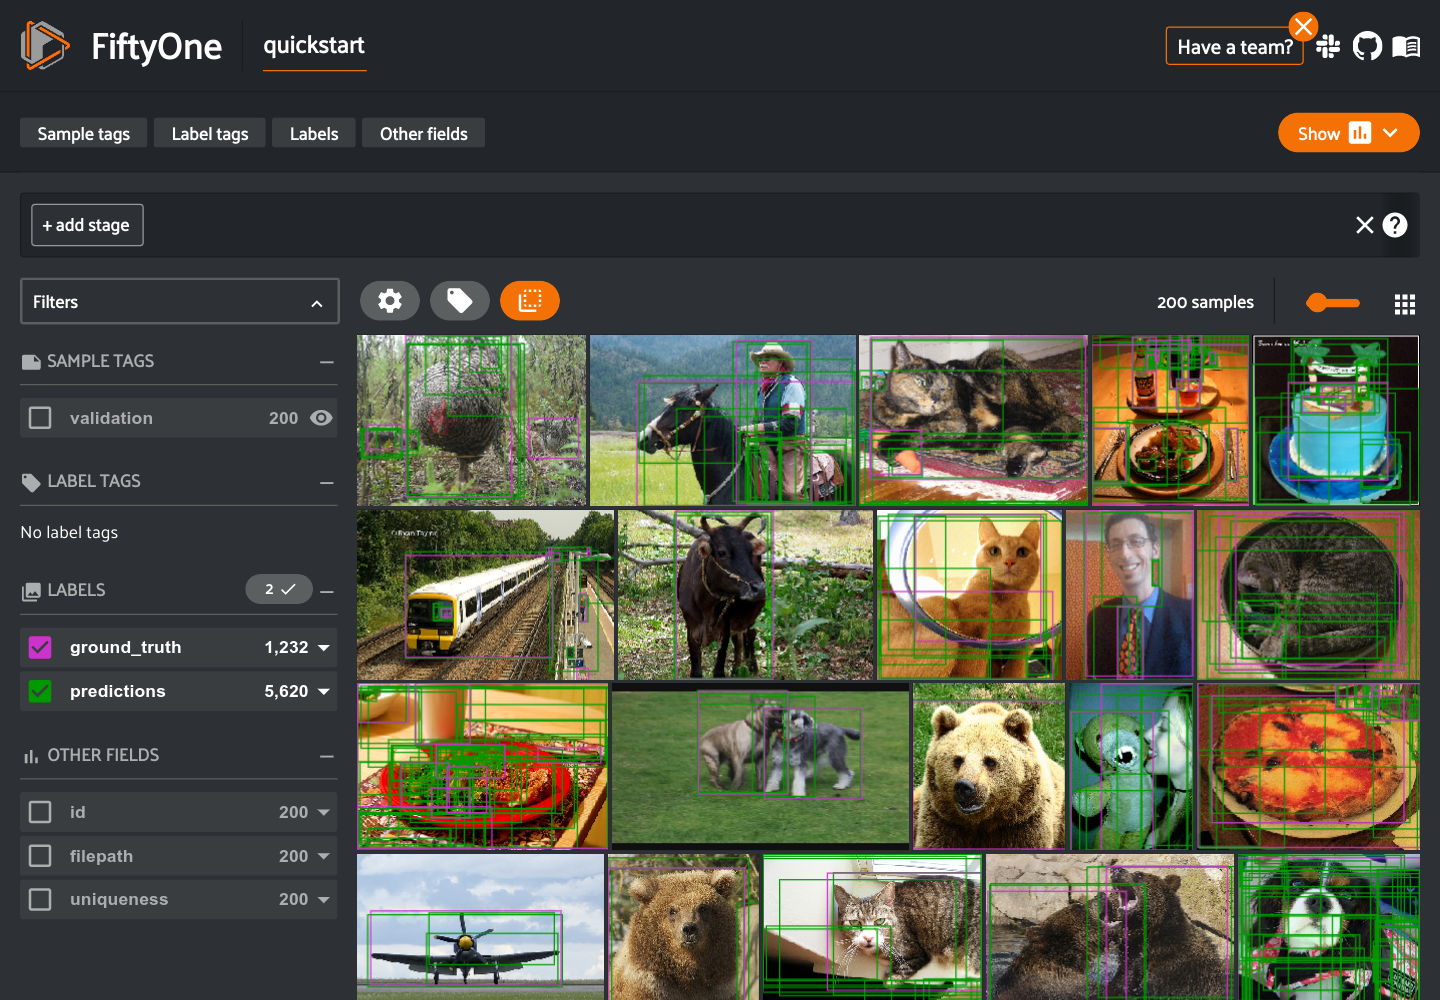

In [2]:
dataset = foz.load_zoo_dataset(name="quickstart",dataset_dir="fiftyone/quickstart")
session = fo.launch_app(dataset)


In [3]:
%reset -f

# Tutorials

## Evaluate object detections
This walkthrough demonstrates how to use FiftyOne to perform hands-on evaluation of your detection model.

It covers the following concepts:

- Loading a dataset with ground truth labels [into FiftyOne](https://voxel51.com/docs/fiftyone/user_guide/dataset_creation/index.html)
- [Adding model predictions](https://voxel51.com/docs/fiftyone/recipes/adding_detections.html) to your dataset
- [Evaluating your model](https://voxel51.com/docs/fiftyone/user_guide/evaluation.html#detections) using FiftyOne’s evaluation API
- Viewing the best and worst performing samples in your dataset

**So, what’s the takeaway?**

Aggregate measures of performance like mAP don’t give you the full picture of your detection model. In practice, the limiting factor on your model’s performance is often data quality issues that you need to see to address. FiftyOne is designed to make it easy to do just that.

Running the workflow presented here on your ML projects will help you to understand the current failure modes (edge cases) of your model and how to fix them, including:

- Identifying scenarios that require additional training samples in order to boost your model’s performance

- Deciding whether your ground truth annotations have errors/weaknesses that need to be corrected before any subsequent model training will be profitable

### Setup

If you haven’t already, install FiftyOne:

``` python
!pip install fiftyone
```
If you run into a ```cv2``` error when importing FiftyOne later on, it is an issue with OpenCV in Colab environments. [Follow these instructions to resolve it.](https://github.com/voxel51/fiftyone/issues/1494#issuecomment-1003148448)

In this tutorial, we’ll use an off-the-shelf [Faster R-CNN detection model](https://pytorch.org/docs/stable/torchvision/models.html#faster-r-cnn) provided by PyTorch. To use it, you’ll need to install ```torch``` and ```torchvision```, if necessary.

``` python
!pip install torch torchvision
```

The following snippet will download the pretrained model from the web and load it:

In [1]:
import torch
import torchvision

# Run the model on GPU if it is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load a pre-trained Faster R-CNN model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.to(device)
model.eval()

print("Model ready")


Model ready


We’ll perform our analysis on the validation split of the [COCO dataset](https://cocodataset.org/#home), which is conveniently available for download via the [FiftyOne Dataset Zoo](https://voxel51.com/docs/fiftyone/user_guide/dataset_zoo/datasets.html#coco-2017).

The snippet below will download the validation split and load it into FiftyOne.

In [2]:
import fiftyone as fo
import fiftyone.zoo as foz

dataset = foz.load_zoo_dataset(
    name="coco-2017", split="validation", dataset_dir="fiftyone/coco")
dataset.persistent=True


Found annotations at 'fiftyone/coco/raw/instances_val2017.json'
Images already downloaded
Existing download of split 'validation' is sufficient
Loading 'coco-2017' split 'validation'
 100% |███████████████| 5000/5000 [41.6s elapsed, 0s remaining, 129.9 samples/s]      
Dataset 'coco-2017-validation' created


Let’s inspect the dataset to see what we downloaded:

In [3]:
# Print some information about the dataset
print(dataset)

Name:        coco-2017-validation
Media type:  image
Num samples: 5000
Persistent:  True
Tags:        ['validation']
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)


In [4]:
# Print a ground truth detection
sample = dataset.first()
print(sample.ground_truth.detections[0])

<Detection: {
    'id': '624578dea2a7557b3090e0b1',
    'attributes': BaseDict({}),
    'tags': BaseList([]),
    'label': 'potted plant',
    'bounding_box': BaseList([
        0.37028125,
        0.3345305164319249,
        0.038593749999999996,
        0.16314553990610328,
    ]),
    'mask': None,
    'confidence': None,
    'index': None,
    'supercategory': 'furniture',
    'iscrowd': 0,
}>


Note that the ground truth detections are stored in the ```ground_truth field``` of the samples.

Before we go further, let’s launch the [FiftyOne App](https://voxel51.com/docs/fiftyone/user_guide/app.html) and use the GUI to explore the dataset visually:


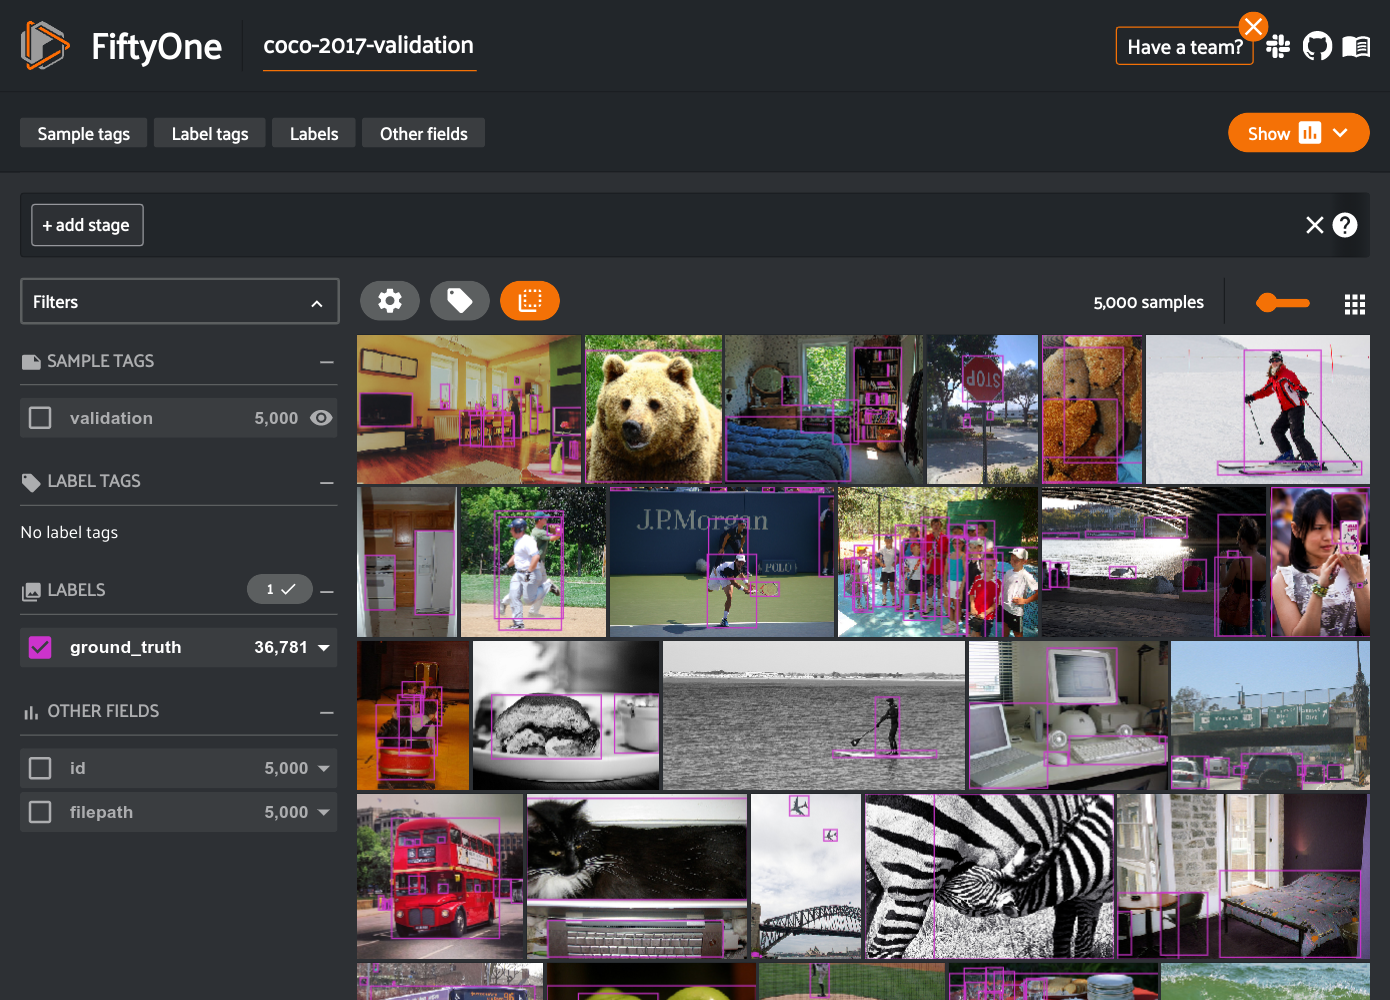

In [5]:
session = fo.launch_app(dataset)

### Add predictions to dataset

Now let’s generate some predictions to analyze.

The code below performs inference with the Faster R-CNN model on a randomly chosen subset of 100 samples from the dataset and stores the resulting predictions in a ```faster_rcnn``` field of the samples.

In [6]:
# Choose a random subset of 100 samples to add predictions to
predictions_view = dataset.take(100, seed=51)

from PIL import Image
from torchvision.transforms import functional as func

import fiftyone as fo

# Get class list
classes = dataset.default_classes

# Add predictions to samples
with fo.ProgressBar() as pb:
    for sample in pb(predictions_view):
        # Load image
        image = Image.open(sample.filepath)
        image = func.to_tensor(image).to(device)
        c, h, w = image.shape

        # Perform inference
        preds = model([image])[0]
        labels = preds["labels"].cpu().detach().numpy()
        scores = preds["scores"].cpu().detach().numpy()
        boxes = preds["boxes"].cpu().detach().numpy()

        # Convert detections to FiftyOne format
        detections = []
        for label, score, box in zip(labels, scores, boxes):
            # Convert to [top-left-x, top-left-y, width, height]
            # in relative coordinates in [0, 1] x [0, 1]
            x1, y1, x2, y2 = box
            rel_box = [x1 / w, y1 / h, (x2 - x1) / w, (y2 - y1) / h]

            detections.append(
                fo.Detection(
                    label=classes[label],
                    bounding_box=rel_box,
                    confidence=score
                )
            )

        # Save predictions to dataset
        sample["faster_rcnn"] = fo.Detections(detections=detections)
        sample.save()

print("Finished adding predictions")

 100% |█████████████████| 100/100 [56.5s elapsed, 0s remaining, 1.6 samples/s]      
Finished adding predictions


In [8]:
print(dataset)

Name:        coco-2017-validation
Media type:  image
Num samples: 5000
Persistent:  True
Tags:        ['validation']
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    faster_rcnn:  fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)


Let’s load ```predictions_view``` in the App to visualize the predictions that we added:

In [7]:
session.view = predictions_view

### Analyzing detections

Let’s analyze the raw predictions we’ve added to our dataset in more detail.
#### Visualizing bounding boxes

Let’s start by loading the full dataset in the App:

In [11]:
# Resets the session; the entire dataset will now be shown
session.view = None

Only the 100 samples in ```predictions_view``` have predictions in their ```faster_rcnn``` field, so some of the samples we see above do not have predicted boxes.

If we want to recover our predictions view, we can do this programmatically via ```session.view = predictions_view```, or we can use the [view bar in the App](https://voxel51.com/docs/fiftyone/user_guide/app.html#using-the-view-bar) to accomplish the same thing:

In [12]:
# Use the view bar to create an `Exists(faster_rcnn, True)` stage
# Now your view contains only the 100 samples with predictions in `faster_rcnn` field
session.show()

Each field of the samples are shown as togglable checkboxes on the left sidebar which can be used to control whether ground truth detections or predictions are rendered on the images.

You can also click on an image to view the sample in more detail:


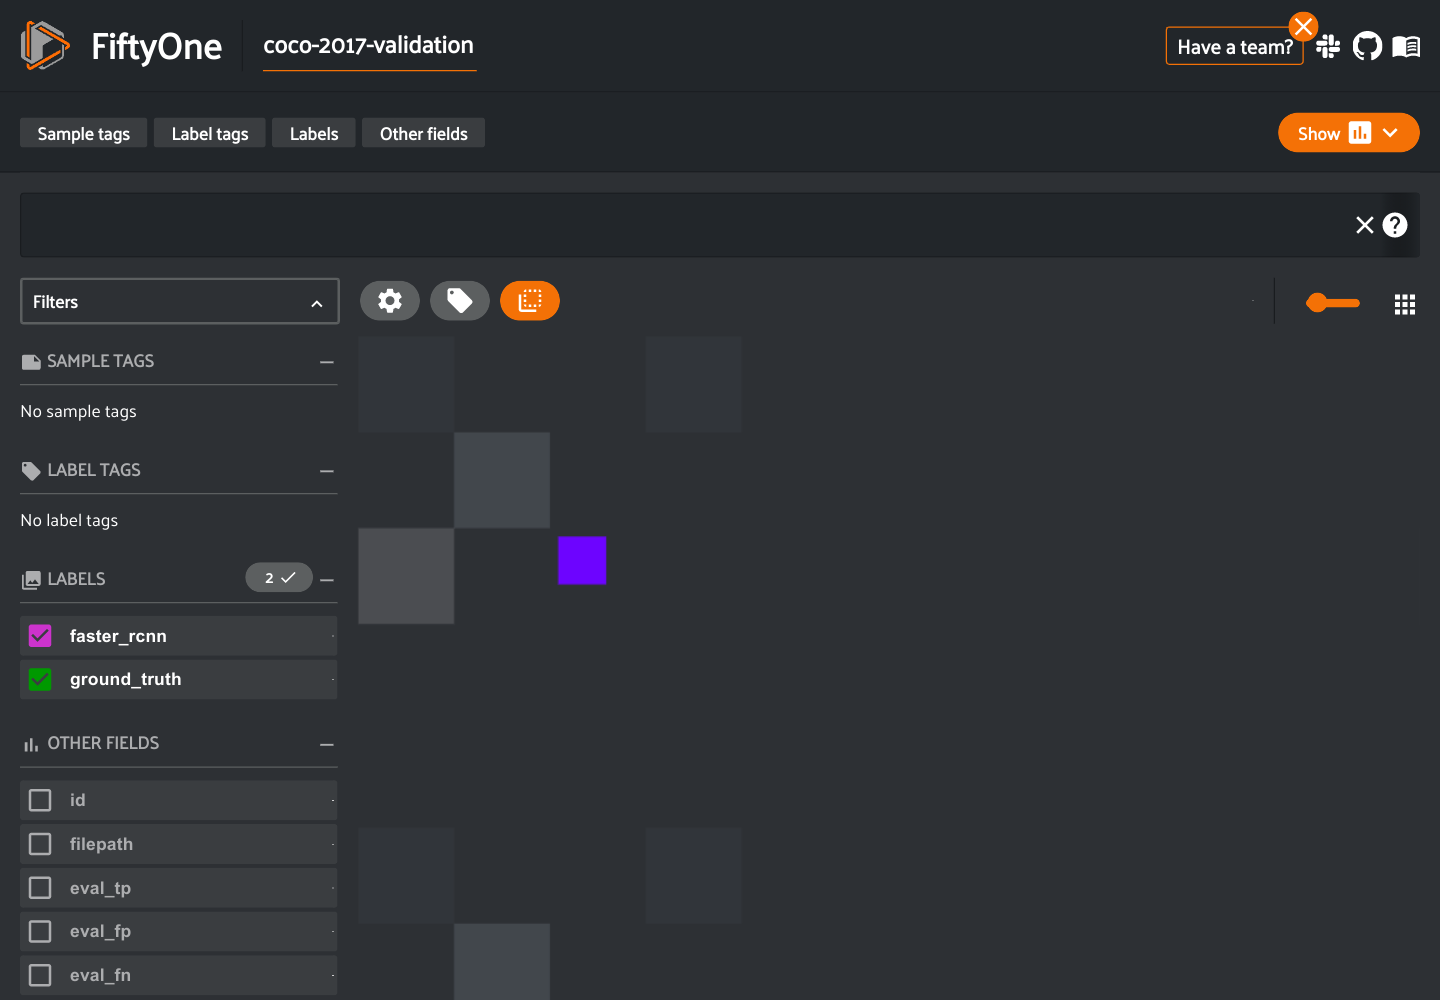

In [13]:
session.show()

#### Selecting samples of interest

You can select images in the App by clicking on the checkbox when hovering over an image. Then, you can create a view that contains only those samples by clicking the orange checkmark with the number of selected samples in the top left corner of the sample grid and clicking ```Only show selected samples```.


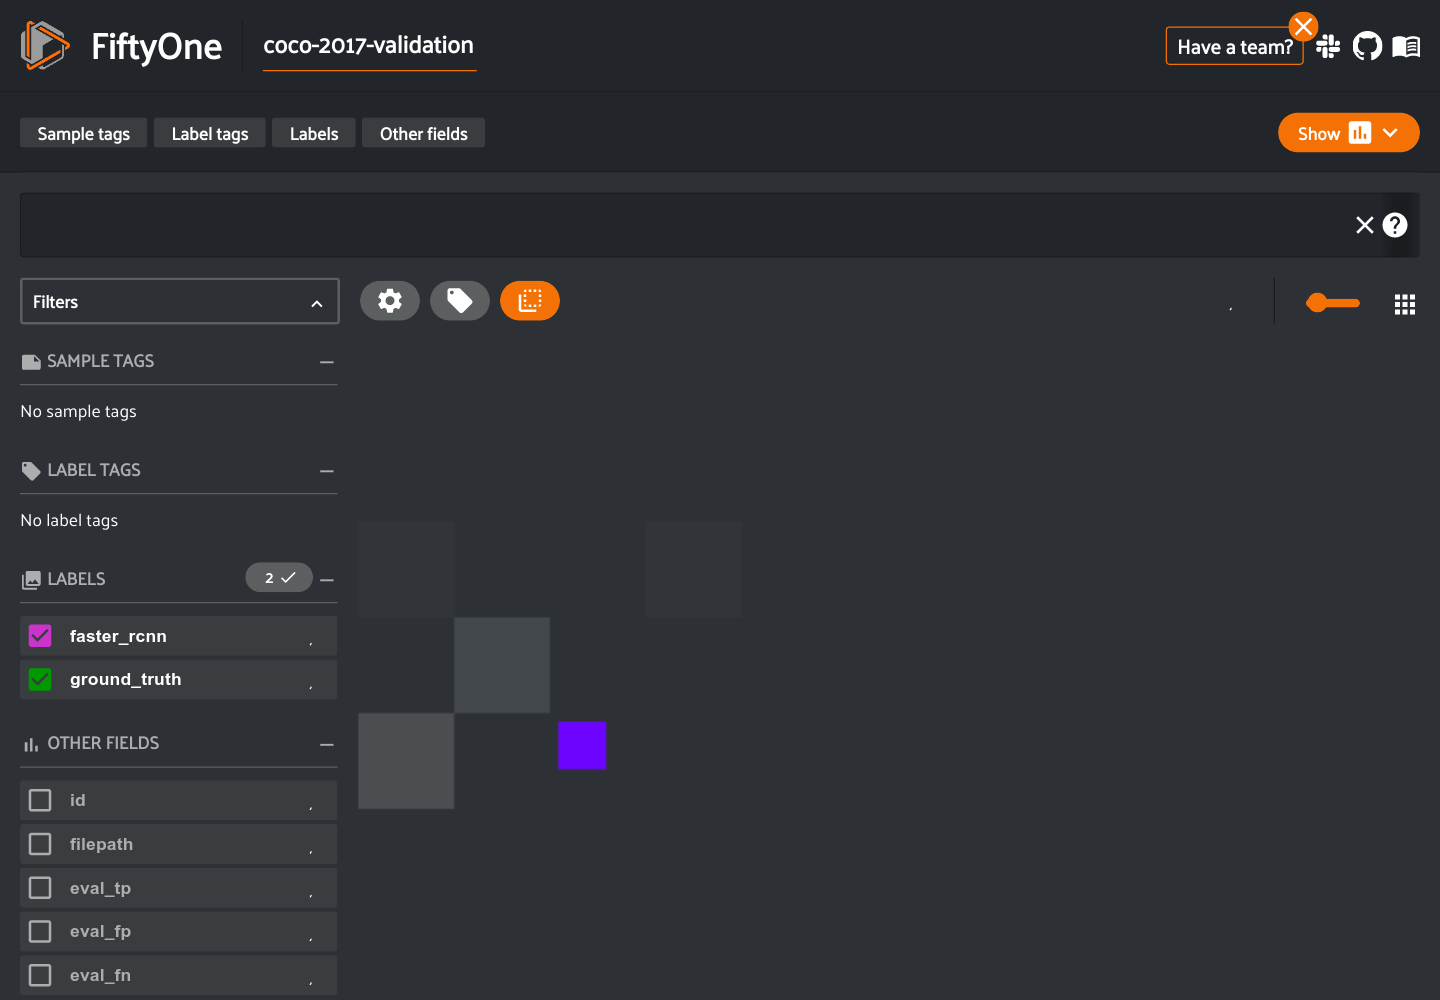

In [14]:
session.show()

Let’s reset our session to show our ```predictions_view```:


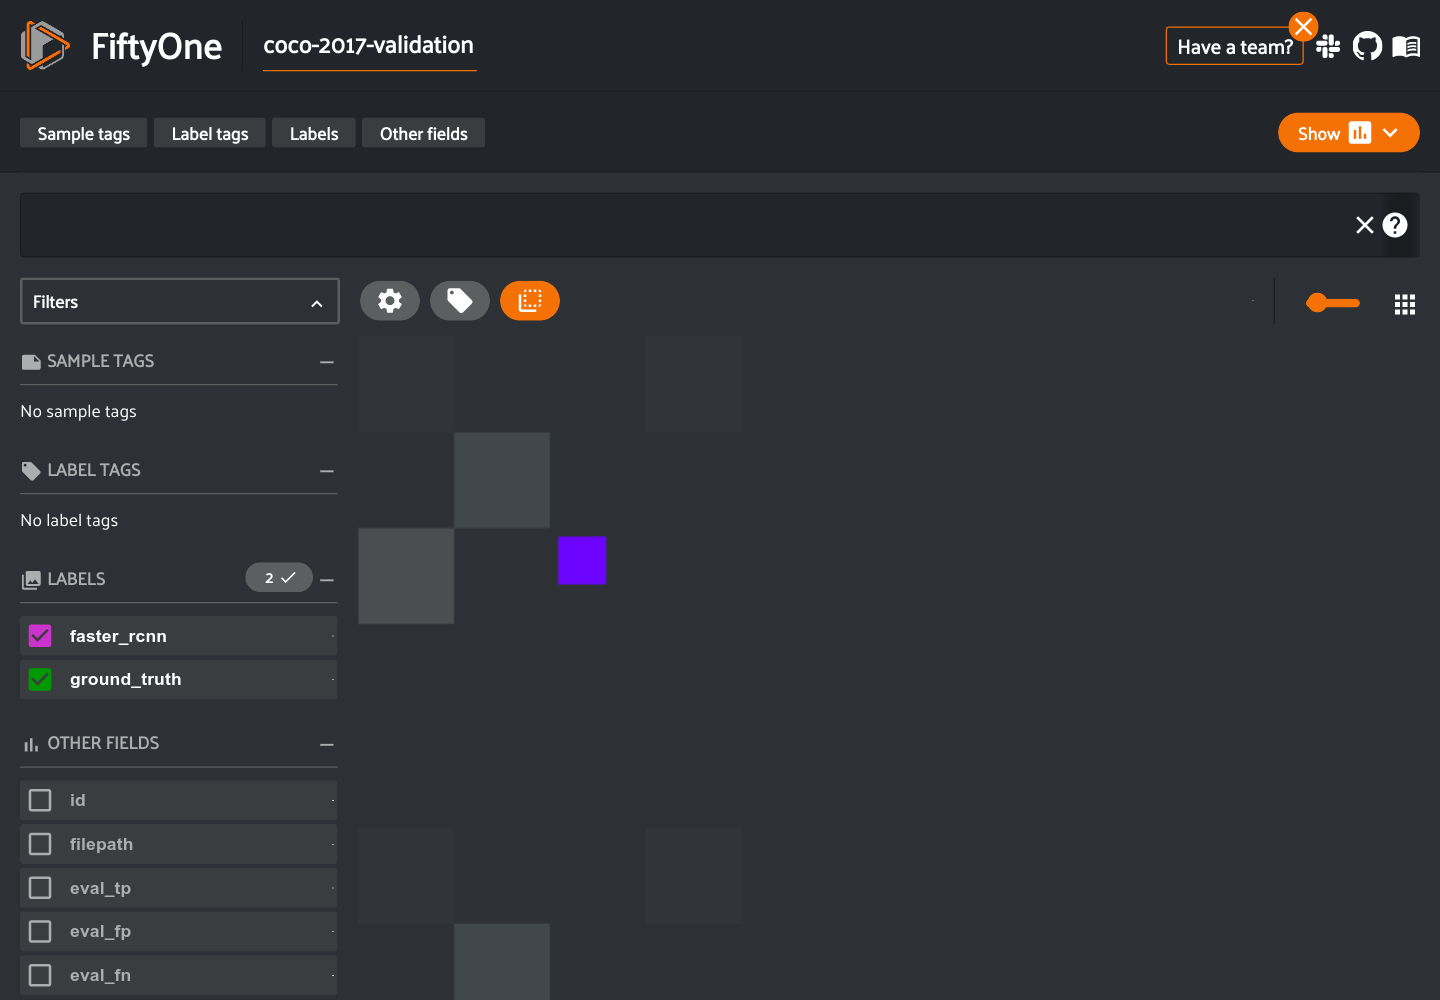

In [15]:
session.view = predictions_view

#### Confidence thresholding in the App

From the App instance above, it looks like our detector is generating some spurious low-quality detections. Let’s use the App to interactively filter the predictions by ```confidence``` to identify a reasonable confidence threshold for our model:


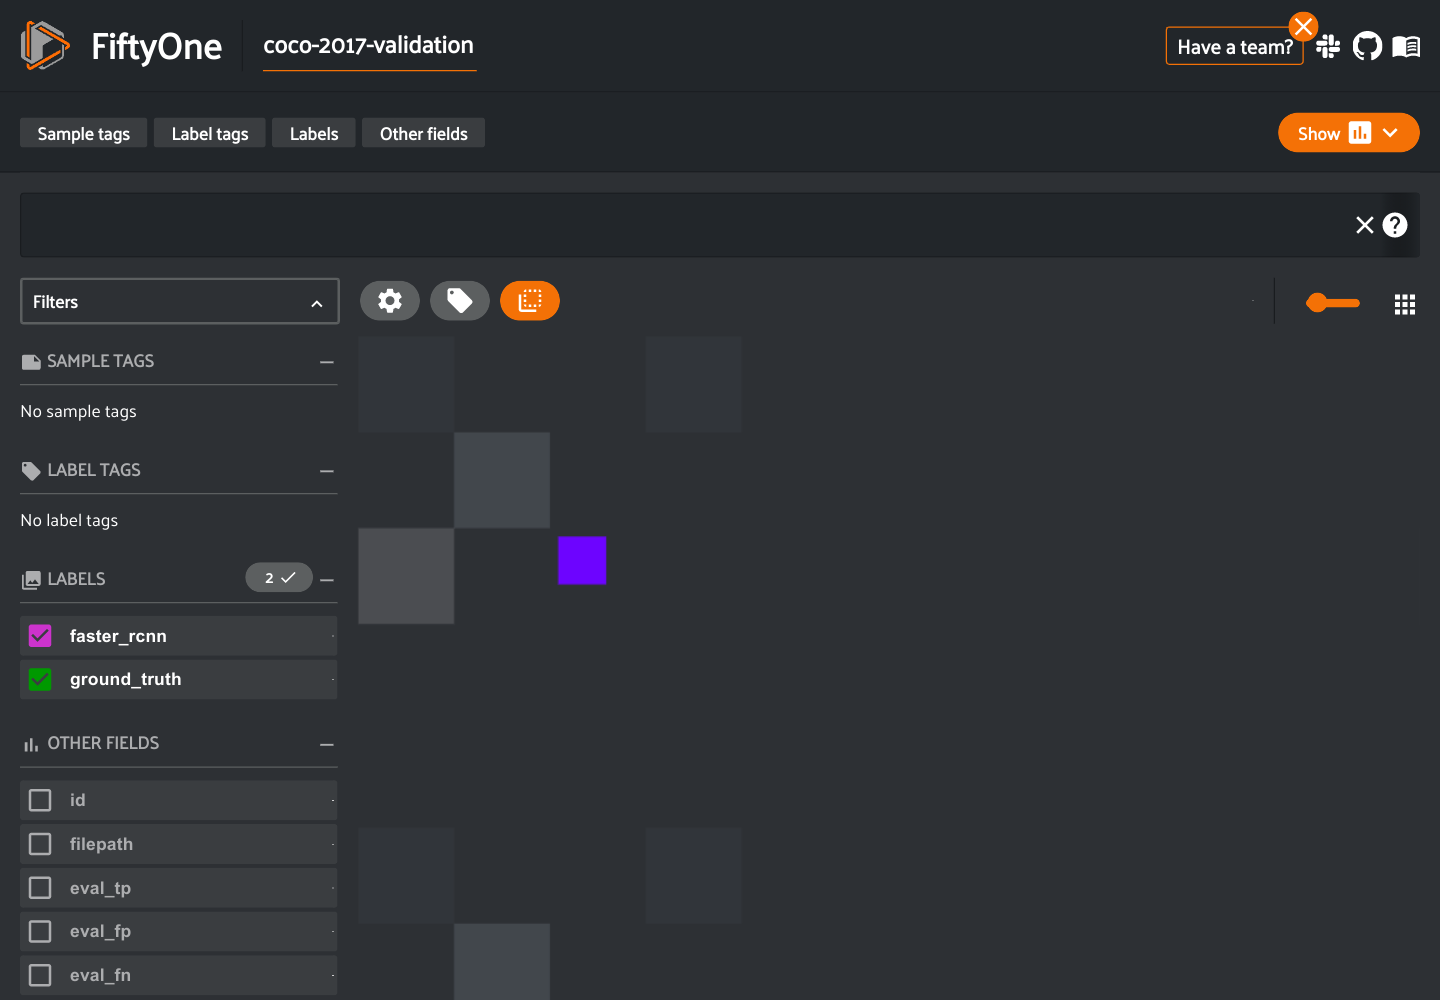

In [16]:
# Click the down caret on the `faster_rcnn` field of Fields Sidebar
# and apply a confidence threshold
session.show()

It looks like a confidence threshold of 0.75 is a good choice for our model, but we’ll confirm that quantitatively later.

#### Confidence thresholding in Python

FiftyOne also provides the ability to [write expressions](https://voxel51.com/docs/fiftyone/user_guide/using_views.html#filtering) that match, filter, and sort detections based on their attributes. See [using DatasetViews](https://voxel51.com/docs/fiftyone/user_guide/using_views.html) for full details.

For example, we can programmatically generate a view that contains only detections whose ```confidence``` is at least ```0.75``` as follows:

In [17]:
from fiftyone import ViewField as F

# Only contains detections with confidence >= 0.75
high_conf_view = predictions_view.filter_labels("faster_rcnn", F("confidence") > 0.75)
# Print some information about the view
print(high_conf_view)

Dataset:     coco-2017-validation
Media type:  image
Num samples: 99
Tags:        ['validation']
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    faster_rcnn:  fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    eval_tp:      fiftyone.core.fields.IntField
    eval_fp:      fiftyone.core.fields.IntField
    eval_fn:      fiftyone.core.fields.IntField
View stages:
    1. Take(size=100, seed=51)
    2. FilterLabels(field='faster_rcnn', filter={'$gt': ['$$this.confidence', 0.75]}, only_matches=True, trajectories=False)


In [18]:
# Print a prediction from the view to verify that its confidence is > 0.75
sample = high_conf_view.first()
print(sample.faster_rcnn.detections[0])

<Detection: {
    'id': '624066ccb34e0b85170d6057',
    'attributes': BaseDict({}),
    'tags': BaseList([]),
    'label': 'person',
    'bounding_box': BaseList([
        0.11384931802749634,
        0.41852003733317056,
        0.30478973388671876,
        0.5001771926879883,
    ]),
    'mask': None,
    'confidence': 0.9776350259780884,
    'index': None,
}>



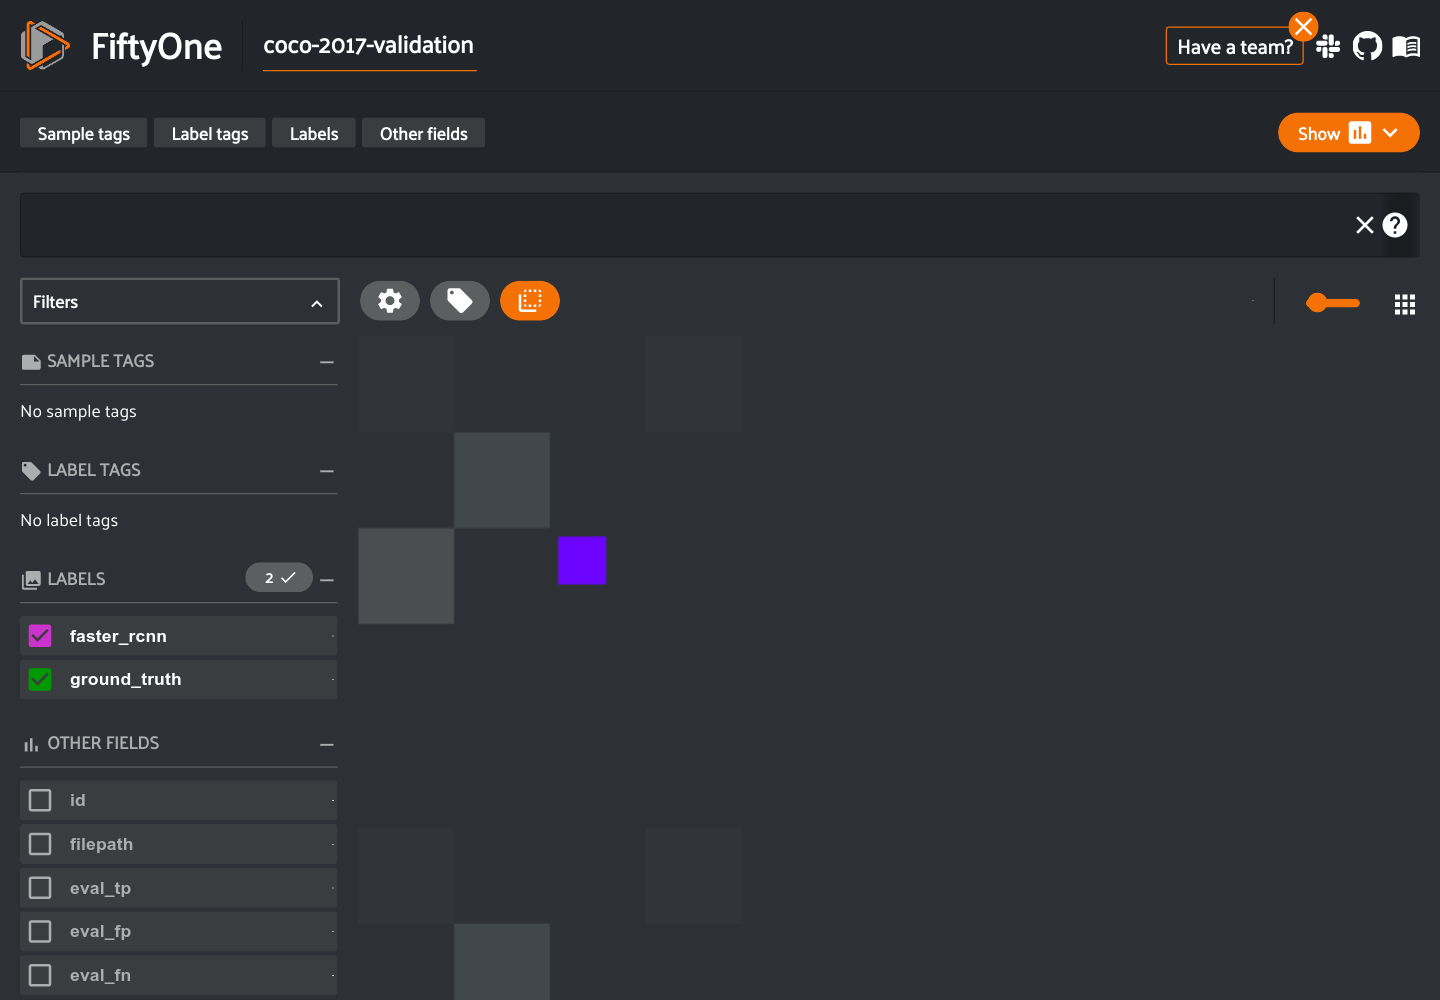

In [19]:
# Load high confidence view in the App
session.view = high_conf_view

#### Viewing object patches

There are multiple situations where it can be useful to visualize each object separately. For example, if a sample contains dozens of objects overlapping one another or if you want to look specifically for instances of a class of objects.

In any case, the FiftyOne App provides a [patches view button](https://voxel51.com/docs/fiftyone/user_guide/app.html#viewing-object-patches) that allows you to take any Detections field in your dataset and visualize each object as an individual patch in the image grid.


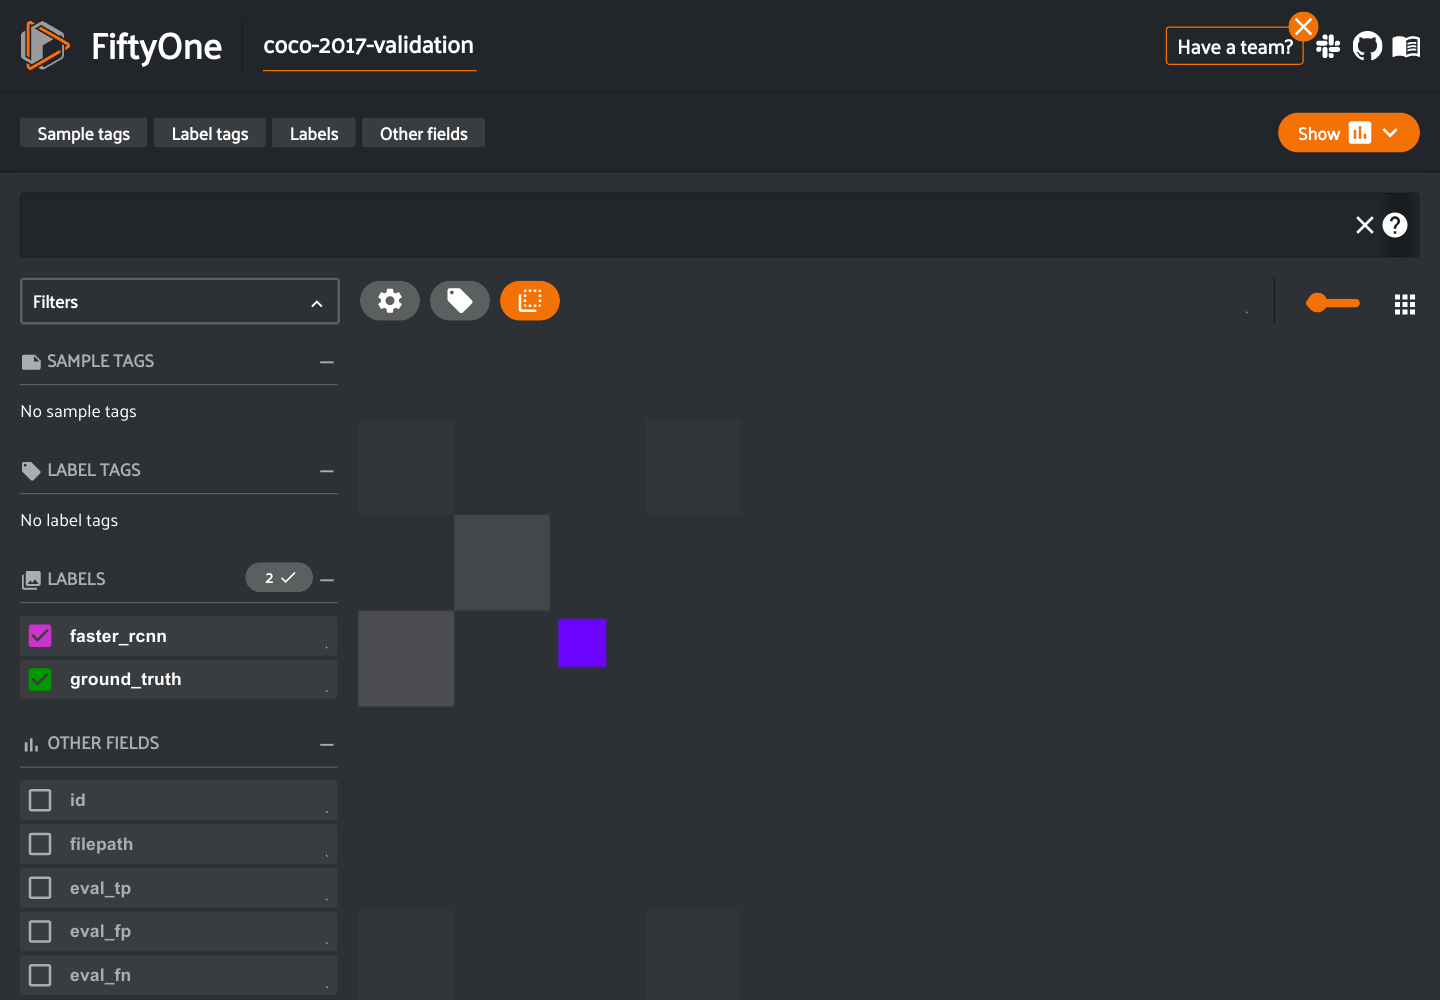

In [20]:
session.view = predictions_view

### Evaluate detections

Now that we have samples with ground truth and predicted objects, let’s use FiftyOne to evaluate the quality of the detections.

FiftyOne provides a powerful [evaluation API](https://voxel51.com/docs/fiftyone/user_guide/evaluation.html) that contains a collection of methods for performing evaluation of model predictions. Since we’re working with object detections here, we’ll use [detection evaluation](https://voxel51.com/docs/fiftyone/user_guide/evaluation.html#detections).

#### Running evaluation

We can run evaluation on our samples via [evaluate_detections()](https://voxel51.com/docs/fiftyone/api/fiftyone.core.collections.html#fiftyone.core.collections.SampleCollection.evaluate_detections). Note that this method is available on both the ```Dataset``` and ```DatasetView``` classes, which means that we can run evaluation on our ```high_conf_view``` to assess the quality of only the high confidence predictions in our dataset.

By default, this method will use the [COCO evaluation protocol](https://cocodataset.org/#detection-eval), plus some extra goodies that we will use later.

In [21]:
# Evaluate the predictions in the `faster_rcnn` field of our `high_conf_view`
# with respect to the objects in the `ground_truth` field
results = high_conf_view.evaluate_detections(
    "faster_rcnn",
    gt_field="ground_truth",
    eval_key="eval",
    compute_mAP=True,
)

Evaluating detections...
 100% |███████████████████| 99/99 [3.2s elapsed, 0s remaining, 41.0 samples/s]      
Performing IoU sweep...
 100% |███████████████████| 99/99 [2.1s elapsed, 0s remaining, 53.8 samples/s]      


#### Aggregate results

The ```results``` object returned by the evaluation routine provides a number of convenient methods for analyzing our predictions.

For example, let’s print a classification report for the top-10 most common classes in the dataset:

In [22]:
# Get the 10 most common classes in the dataset
counts = dataset.count_values("ground_truth.detections.label")
classes_top10 = sorted(counts, key=counts.get, reverse=True)[:10]

# Print a classification report for the top-10 classes
results.print_report(classes=classes_top10)

               precision    recall  f1-score   support

       person       0.84      0.82      0.83       224
          car       0.39      0.47      0.42        15
        chair       0.79      0.37      0.50        63
         book       1.00      0.17      0.29        18
       bottle       0.69      0.67      0.68        30
          cup       0.62      0.45      0.53        22
 dining table       0.25      0.12      0.16        25
traffic light       0.00      0.00      0.00         0
         bowl       0.67      0.40      0.50        10
      handbag       0.57      0.33      0.42        12

    micro avg       0.76      0.62      0.68       419
    macro avg       0.58      0.38      0.43       419
 weighted avg       0.75      0.62      0.66       419



We can also compute the mean average-precision (mAP) of our detector:

In [23]:
print(results.mAP())

0.40518571535793835


Since [evaluate_detections()](https://voxel51.com/docs/fiftyone/api/fiftyone.core.collections.html#fiftyone.core.collections.SampleCollection.evaluate_detections) uses the official [COCO evaluation protocol](https://cocodataset.org/#detection-eval), this mAP value will match what ```pycocotools``` would report.
We can also view some precision-recall (PR) curves for specific classes of our model:

In [24]:
# plot = results.plot_pr_curves(classes=["person", "car"])
# plot.show()

#### Sample-level analysis

The evaluation routine also populated some new fields on our dataset that contain helpful information that we can use to evaluate our predictions at the sample-level.

In particular, each sample now contains new fields:

- ```eval_tp```: the number of true positive (TP) predictions in the sample

- ```eval_fp```: the number of false positive (FP) predictions in the sample

- ```eval_fn```: the number of false negative (FN) predictions in the sample


In [25]:
# Our dataset's schema now contains `eval_*` fields
print(dataset)

Name:        coco-2017-validation
Media type:  image
Num samples: 5000
Persistent:  True
Tags:        ['validation']
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    faster_rcnn:  fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    eval_tp:      fiftyone.core.fields.IntField
    eval_fp:      fiftyone.core.fields.IntField
    eval_fn:      fiftyone.core.fields.IntField


The individual predicted and ground truth objects also have fields populated on them describing the results of the matching process:

- ```eval```: whether the object is a TP/FP/FN

- ```eval_id```: the ID of the matching ground truth/predicted object, if any

- ```eval_iou```: the IoU between the matching objects, if any


In [26]:
# Our detections have helpful evaluation data on them
sample = high_conf_view.first()
print(sample.faster_rcnn.detections[0])

<Detection: {
    'id': '624066ccb34e0b85170d6057',
    'attributes': BaseDict({}),
    'tags': BaseList([]),
    'label': 'person',
    'bounding_box': BaseList([
        0.11384931802749634,
        0.41852003733317056,
        0.30478973388671876,
        0.5001771926879883,
    ]),
    'mask': None,
    'confidence': 0.9776350259780884,
    'index': None,
    'eval_iou': 0.7459312636121747,
    'eval_id': '62403c4a6f0491511e4a310a',
    'eval': 'tp',
}>


These extra fields were added because we provided the ```eval_key``` parameter to [evaluate_detections()](https://voxel51.com/docs/fiftyone/api/fiftyone.core.collections.html#fiftyone.core.collections.SampleCollection.evaluate_detections). If we had omitted this parameter, then no information would have been recorded on our samples.

Don’t worry, if you forget what evaluations you’ve run, you can retrieve information about the evaluation later:

In [27]:
print(dataset.list_evaluations())
print(dataset.get_evaluation_info("eval"))

['eval']
{
    "key": "eval",
    "version": "0.15.0.1",
    "timestamp": "2022-03-27T13:30:23.300000",
    "config": {
        "method": "coco",
        "cls": "fiftyone.utils.eval.coco.COCOEvaluationConfig",
        "pred_field": "faster_rcnn",
        "gt_field": "ground_truth",
        "iou": 0.5,
        "classwise": true,
        "iscrowd": "iscrowd",
        "use_masks": false,
        "use_boxes": false,
        "tolerance": null,
        "compute_mAP": true,
        "iou_threshs": [
            0.5,
            0.55,
            0.6,
            0.65,
            0.7,
            0.75,
            0.8,
            0.85,
            0.9,
            0.95
        ],
        "max_preds": 100,
        "error_level": 1
    }
}


You can even load the view on which you ran an evaluation by calling the [load_evaluation_view()](https://voxel51.com/docs/fiftyone/api/fiftyone.core.collections.html?highlight=load_evaluation_view#fiftyone.core.collections.SampleCollection.load_evaluation_view) method on the parent dataset:

In [28]:
# Load the view on which we ran the `eval` evaluation
eval_view = dataset.load_evaluation_view("eval")
print(eval_view)

Dataset:     coco-2017-validation
Media type:  image
Num samples: 99
Tags:        ['validation']
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    faster_rcnn:  fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    eval_tp:      fiftyone.core.fields.IntField
    eval_fp:      fiftyone.core.fields.IntField
    eval_fn:      fiftyone.core.fields.IntField
View stages:
    1. Take(size=100, seed=51)
    2. FilterLabels(field='faster_rcnn', filter={'$gt': ['$$this.confidence', 0.75]}, only_matches=True, trajectories=False)


Finally, you can delete an evaluation from a dataset, including any information that was added to your samples, by calling [delete_evaluation()](https://voxel51.com/docs/fiftyone/api/fiftyone.core.collections.html#fiftyone.core.collections.SampleCollection.delete_evaluation).

### Evaluation views

So, now that we have a sense for the aggregate performance of our model, let’s dive into sample-level analysis by creating an [evaluation view](https://voxel51.com/docs/fiftyone/user_guide/app.html#viewing-evaluation-patches).

Any evaluation that you stored on your dataset can be used to generate an [evaluation view](https://voxel51.com/docs/fiftyone/user_guide/app.html#viewing-evaluation-patches) that is a patches view creating a sample for every true positive, false positive, and false negative in your dataset. Through this view, you can quickly filter and sort evaluated detections by their type (TP/FP/FN), evaluated IoU, and if they are matched to a crowd object.

These evaluation views can be created through Python or directly in the App as shown below.

In [29]:
eval_patches = dataset.to_evaluation_patches("eval")
print(eval_patches)

Dataset:     coco-2017-validation
Media type:  image
Num patches: 40235
Tags:        ['validation']
Patch fields:
    id:           fiftyone.core.fields.ObjectIdField
    sample_id:    fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    faster_rcnn:  fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    crowd:        fiftyone.core.fields.BooleanField
    type:         fiftyone.core.fields.StringField
    iou:          fiftyone.core.fields.FloatField
View stages:
    1. ToEvaluationPatches(eval_key='eval', config=None)



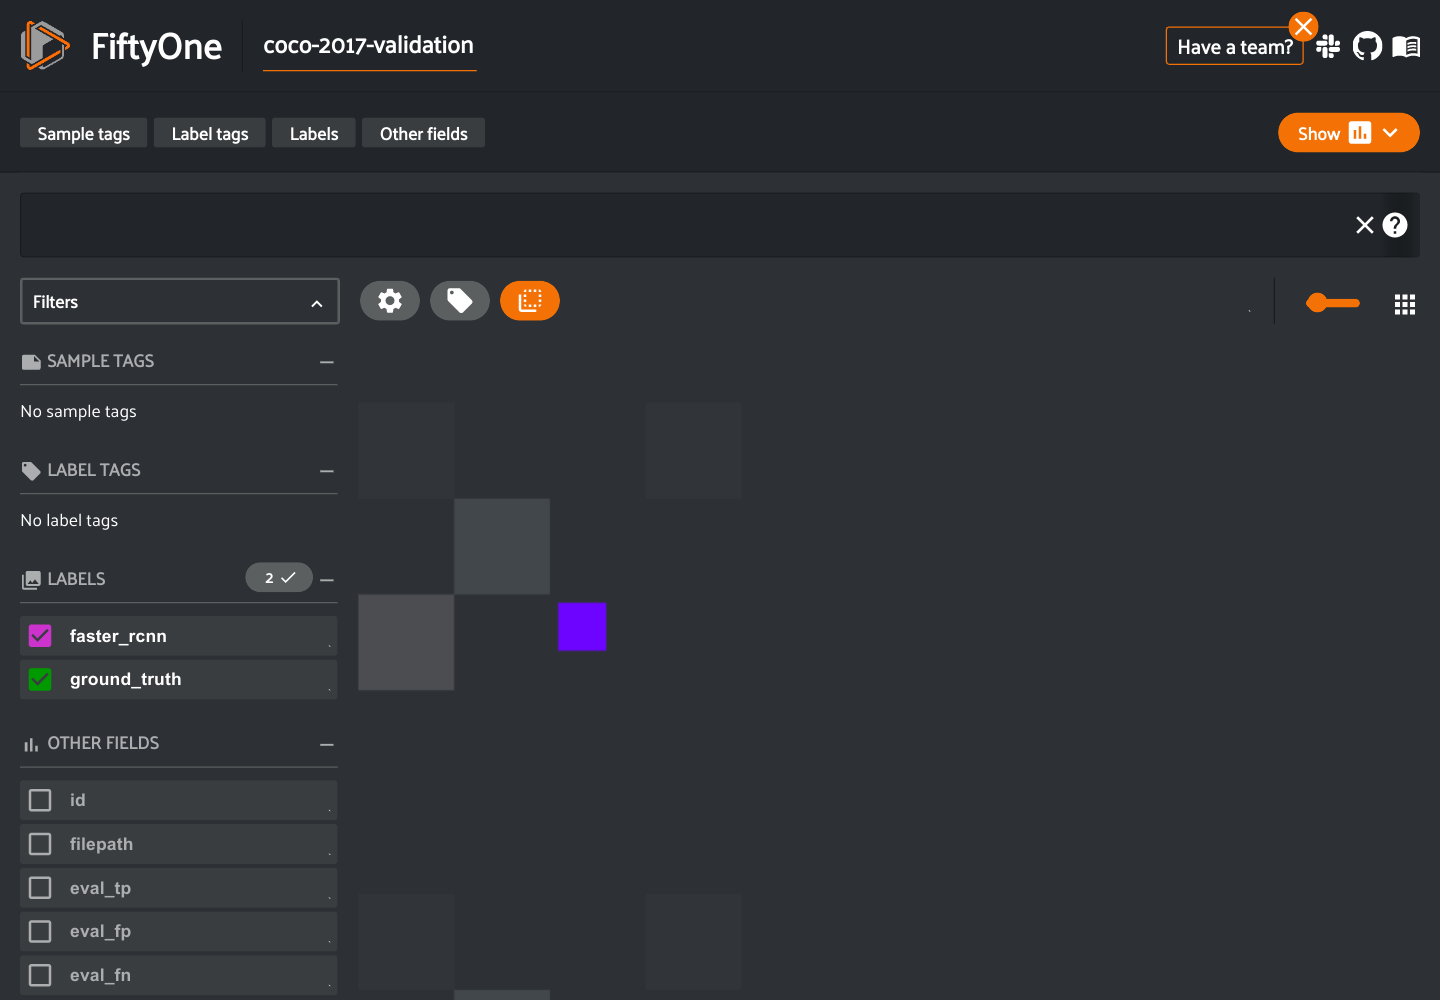

In [30]:
session.view = high_conf_view

Let’s use this evaluation view to find individual false positive detections with a confidence of 0.85 or greater.


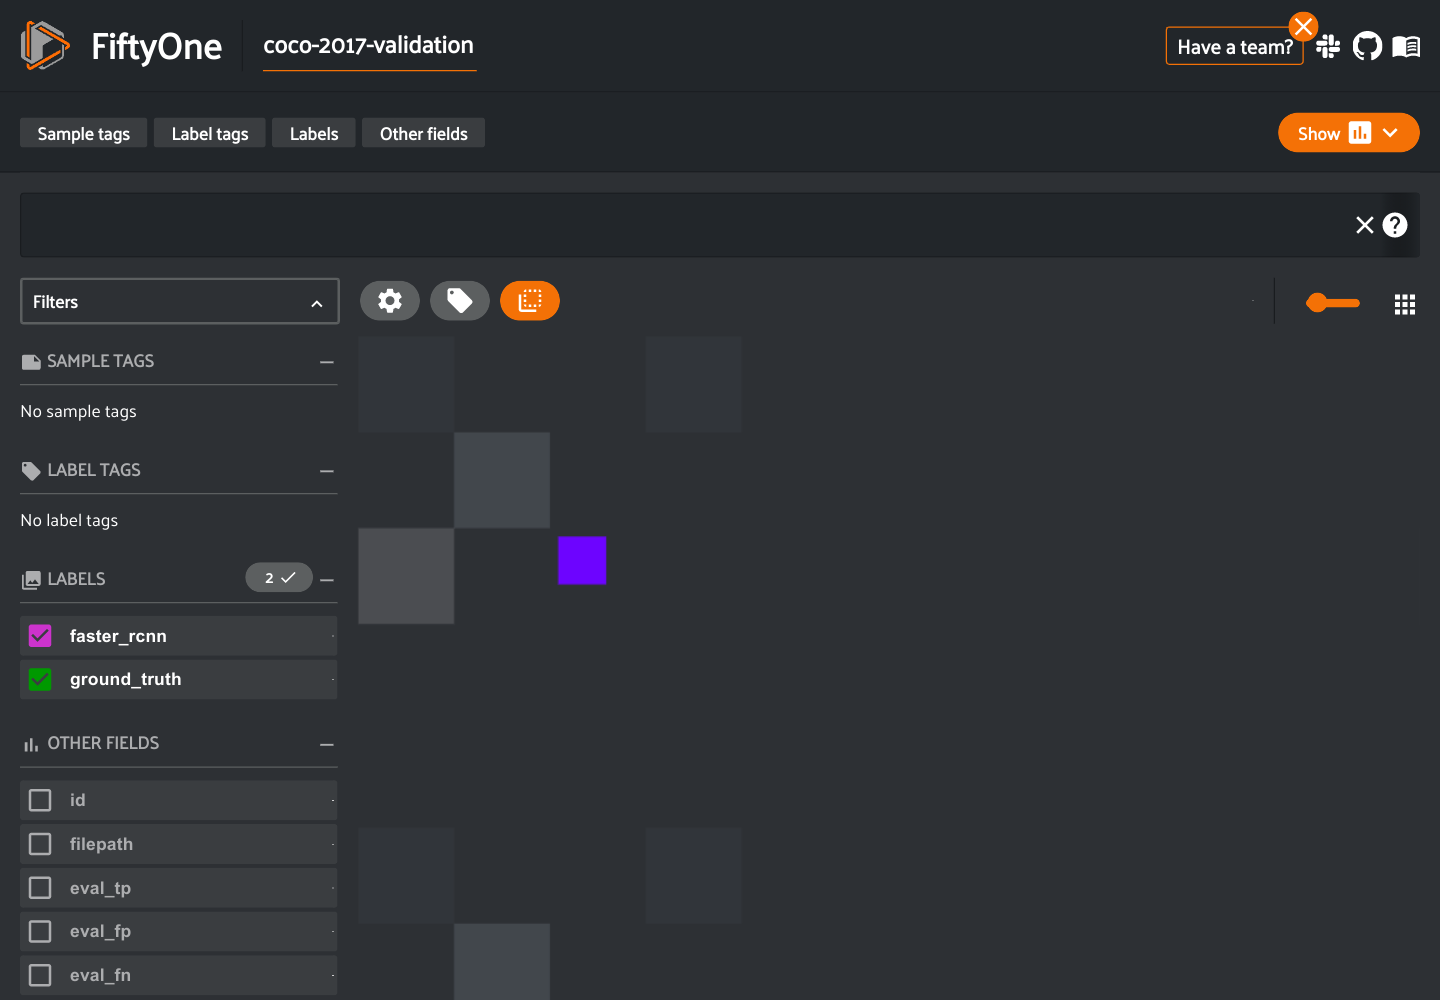

In [31]:
session.view = high_conf_view

#### View the best-performing samples

To dig in further, let’s create a view that sorts by ```eval_tp``` so we can see the best-performing cases of our model (i.e., the samples with the most correct predictions):


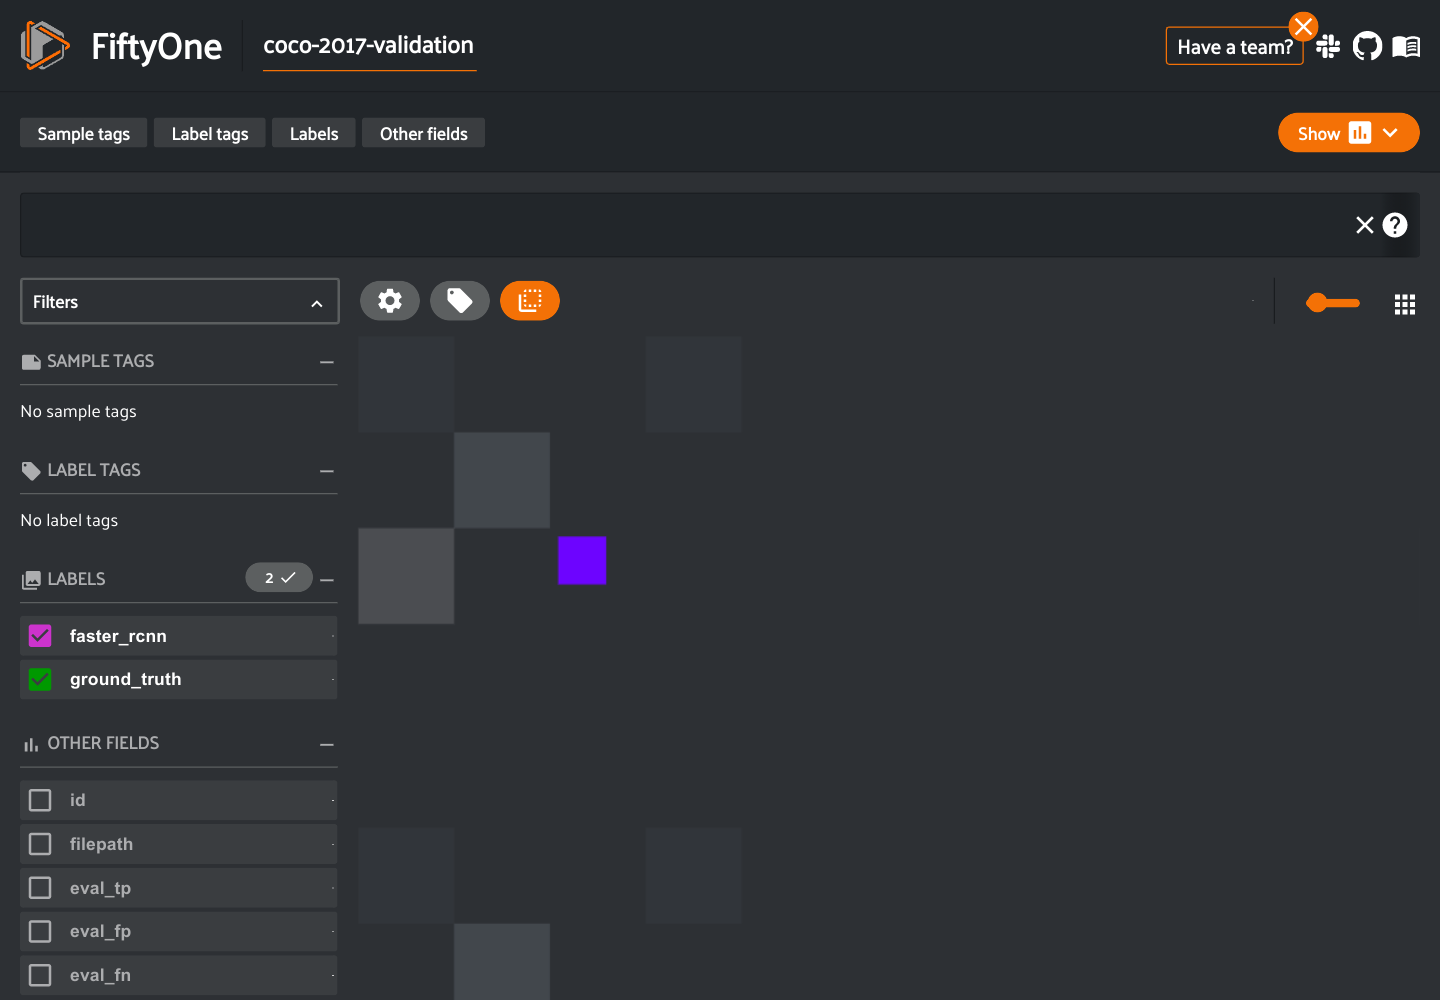

In [32]:
# Show samples with most true positives
session.view = high_conf_view.sort_by("eval_tp", reverse=True)

#### View the worst-performing samples

Similarly, we can sort by the ```eval_fp``` field to see the worst-performing cases of our model (i.e., the samples with the most false positive predictions):


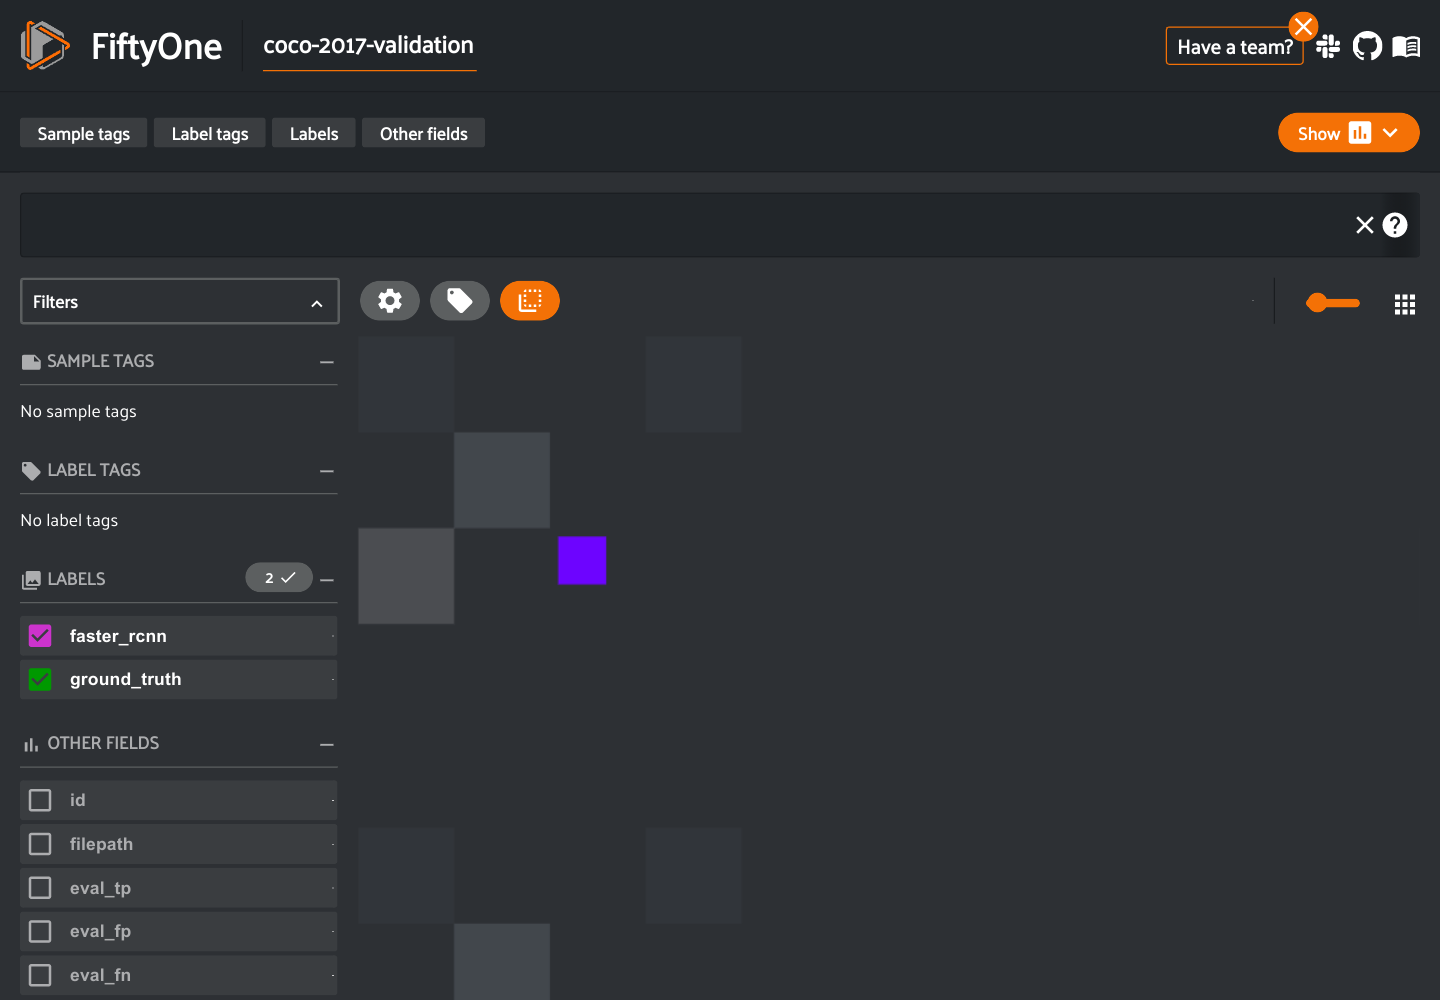

In [33]:
# Show samples with most false positives
session.view = high_conf_view.sort_by("eval_fp", reverse=True)

#### Filtering by bounding box area

[Dataset views](https://voxel51.com/docs/fiftyone/user_guide/using_views.html) are extremely powerful. For example, let’s look at how our model performed on small objects by creating a view that contains only predictions whose bounding box area is less than ```32^2``` pixels:


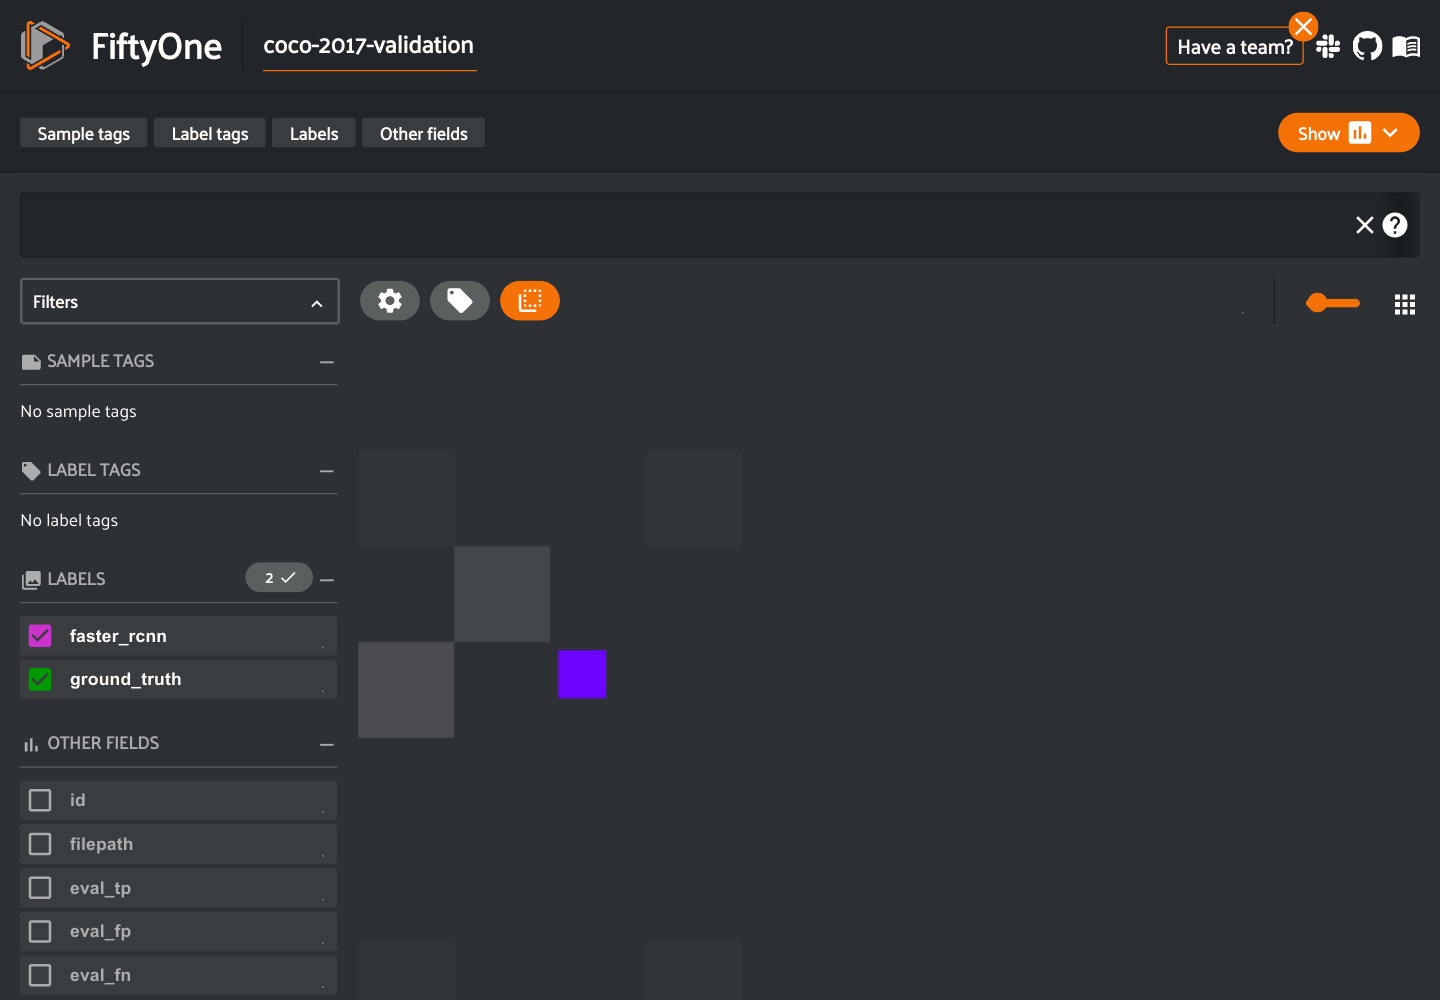

In [34]:
# Compute metadata so we can reference image height/width in our view
dataset.compute_metadata()
#
# Create an expression that will match objects whose bounding boxes have
# area less than 32^2 pixels
#
# Bounding box format is [top-left-x, top-left-y, width, height]
# with relative coordinates in [0, 1], so we multiply by image
# dimensions to get pixel area
#
bbox_area = (
    F("$metadata.width") * F("bounding_box")[2] *
    F("$metadata.height") * F("bounding_box")[3]
)
small_boxes = bbox_area < 32 ** 2

# Create a view that contains only small (and high confidence) predictions
small_boxes_view = high_conf_view.filter_labels("faster_rcnn", small_boxes)

session.view = small_boxes_view


We can always re-run evaluation to see how our detector fairs on only small boxes:

In [35]:
# Create a view that contains only small GT and predicted boxes
small_boxes_eval_view = (
    high_conf_view
    .filter_labels("ground_truth", small_boxes)
    .filter_labels("faster_rcnn", small_boxes)
)

# Run evaluation
small_boxes_results = small_boxes_eval_view.evaluate_detections(
    "faster_rcnn",
    gt_field="ground_truth",
)

Evaluating detections...
 100% |███████████████████| 29/29 [487.7ms elapsed, 0s remaining, 59.5 samples/s]      


In [36]:
# Get the 10 most common small object classes
small_counts = small_boxes_eval_view.count_values("ground_truth.detections.label")
classes_top10_small = sorted(small_counts, key=counts.get, reverse=True)[:10]

# Print a classification report for the top-10 small object classes
small_boxes_results.print_report(classes=classes_top10_small)

              precision    recall  f1-score   support

      person       0.57      0.67      0.62        48
         car       0.45      0.83      0.59         6
       chair       0.50      0.12      0.19        17
        book       1.00      0.22      0.36         9
      bottle       0.60      0.33      0.43         9
         cup       0.67      0.25      0.36         8
dining table       0.00      0.00      0.00         7
        bowl       0.50      0.25      0.33         4
     handbag       0.50      0.12      0.20         8
       truck       1.00      0.14      0.25         7

   micro avg       0.57      0.40      0.47       123
   macro avg       0.58      0.29      0.33       123
weighted avg       0.58      0.40      0.41       123



### Viewing detections in a crowd

If you’re familiar with the [COCO data format](https://cocodataset.org/#format-data), you’ll know that the ground truth annotations have an iscrowd = 0/1 attribute that indicates whether a box contains multiple instances of the same object.

In [37]:
# View the `iscrowd` attribute on a ground truth object
sample = dataset.first()
print(sample.ground_truth.detections[0])

<Detection: {
    'id': '62403c336f0491511e490d44',
    'attributes': BaseDict({}),
    'tags': BaseList([]),
    'label': 'potted plant',
    'bounding_box': BaseList([
        0.37028125,
        0.3345305164319249,
        0.038593749999999996,
        0.16314553990610328,
    ]),
    'mask': None,
    'confidence': None,
    'index': None,
    'supercategory': 'furniture',
    'iscrowd': 0,
}>


Let’s create a view that contains only samples with at least one detection for which ```iscrowd``` is 1:


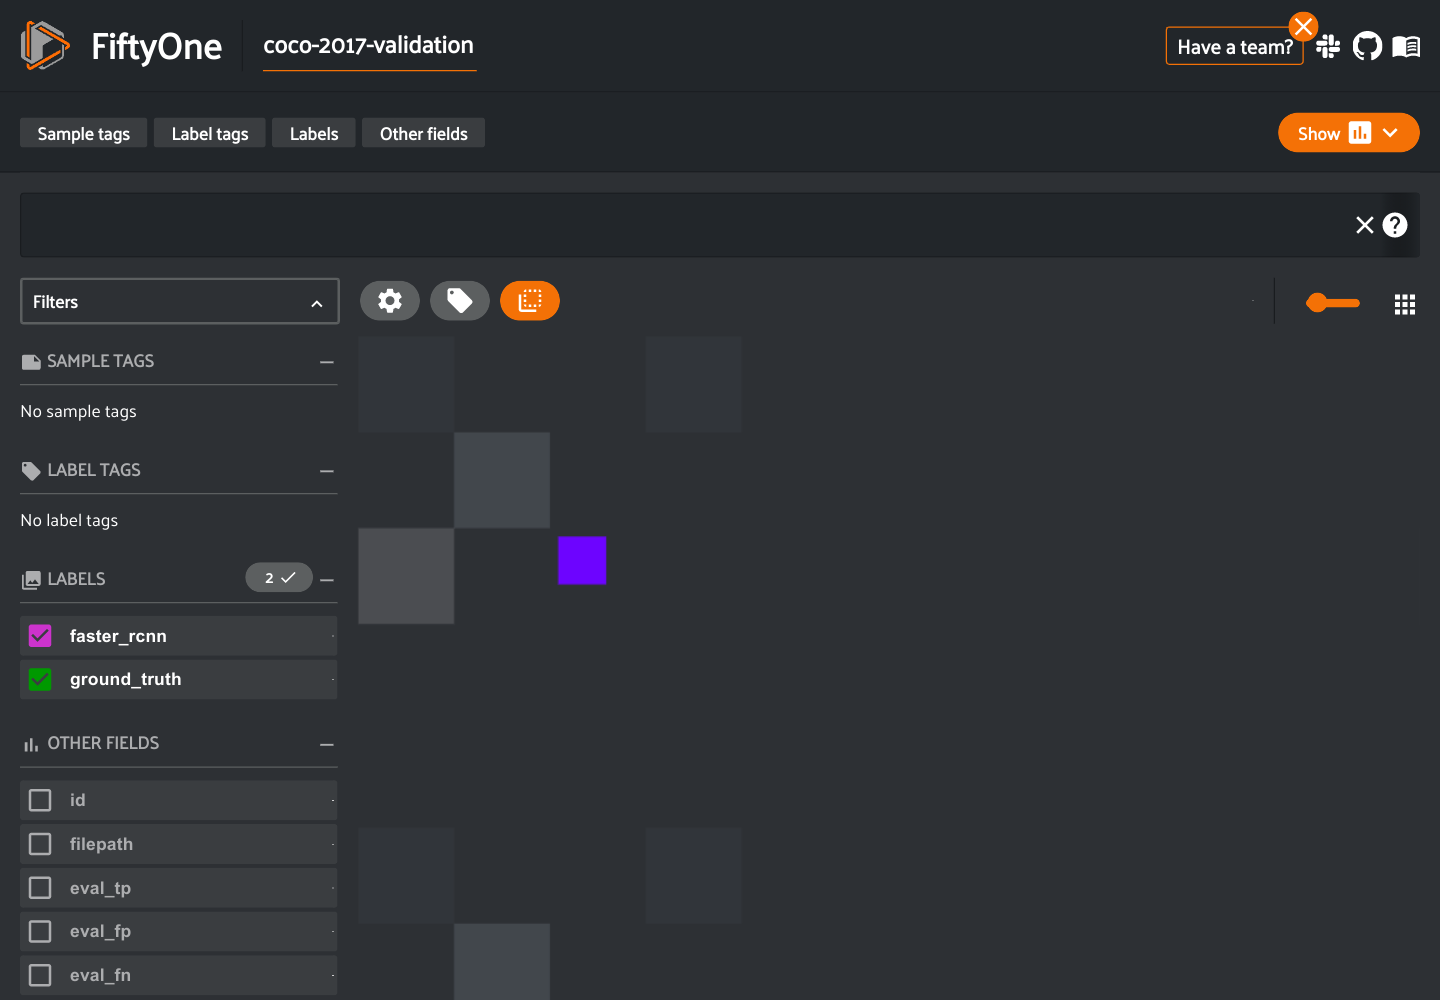

In [38]:
# Create a view that contains only samples for which at least one detection has
# its iscrowd attribute set to 1
crowded_images_view = high_conf_view.match(
    F("ground_truth.detections").filter(F("attributes.iscrowd.value") == 1).length() > 0
)

session.view = crowded_images_view

### More complex insights

Let’s combine our previous operations to form more complex queries that provide deeper insight into the quality of our detections.

For example, let’s sort our view of crowded images from the previous section in decreasing order of false positive counts, so that we can see samples that have many (allegedly) spurious predictions in images that are known to contain crowds of objects:


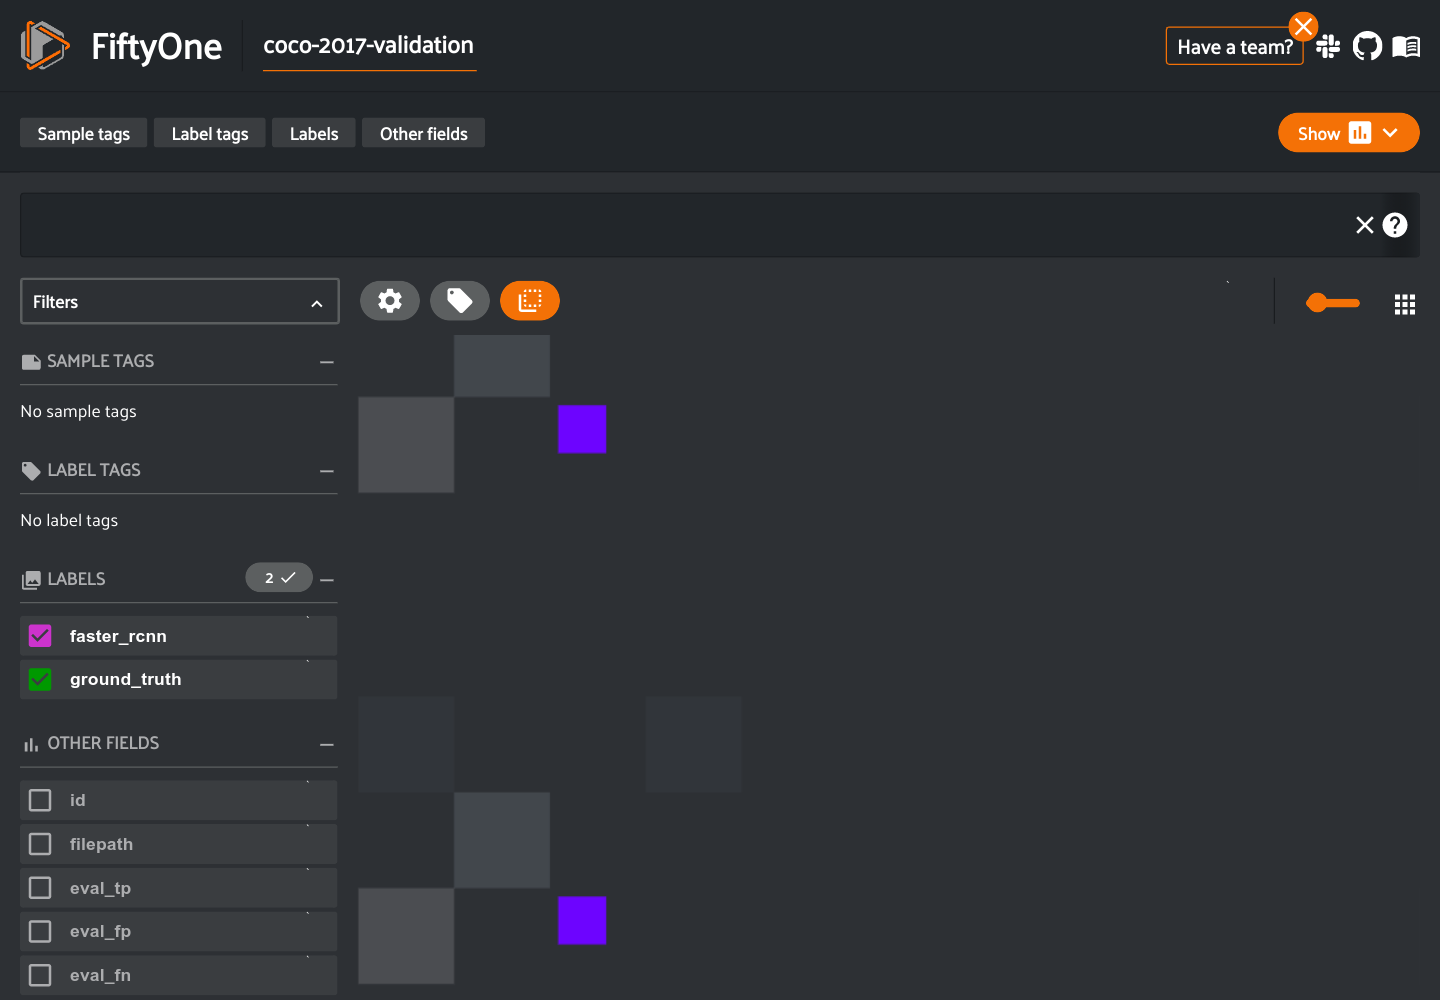

In [39]:
session.view = crowded_images_view.sort_by("eval_fp", reverse=True)

Let’s compare the above view to another view that just sorts by false positive count, regardless of whether the image is crowded:


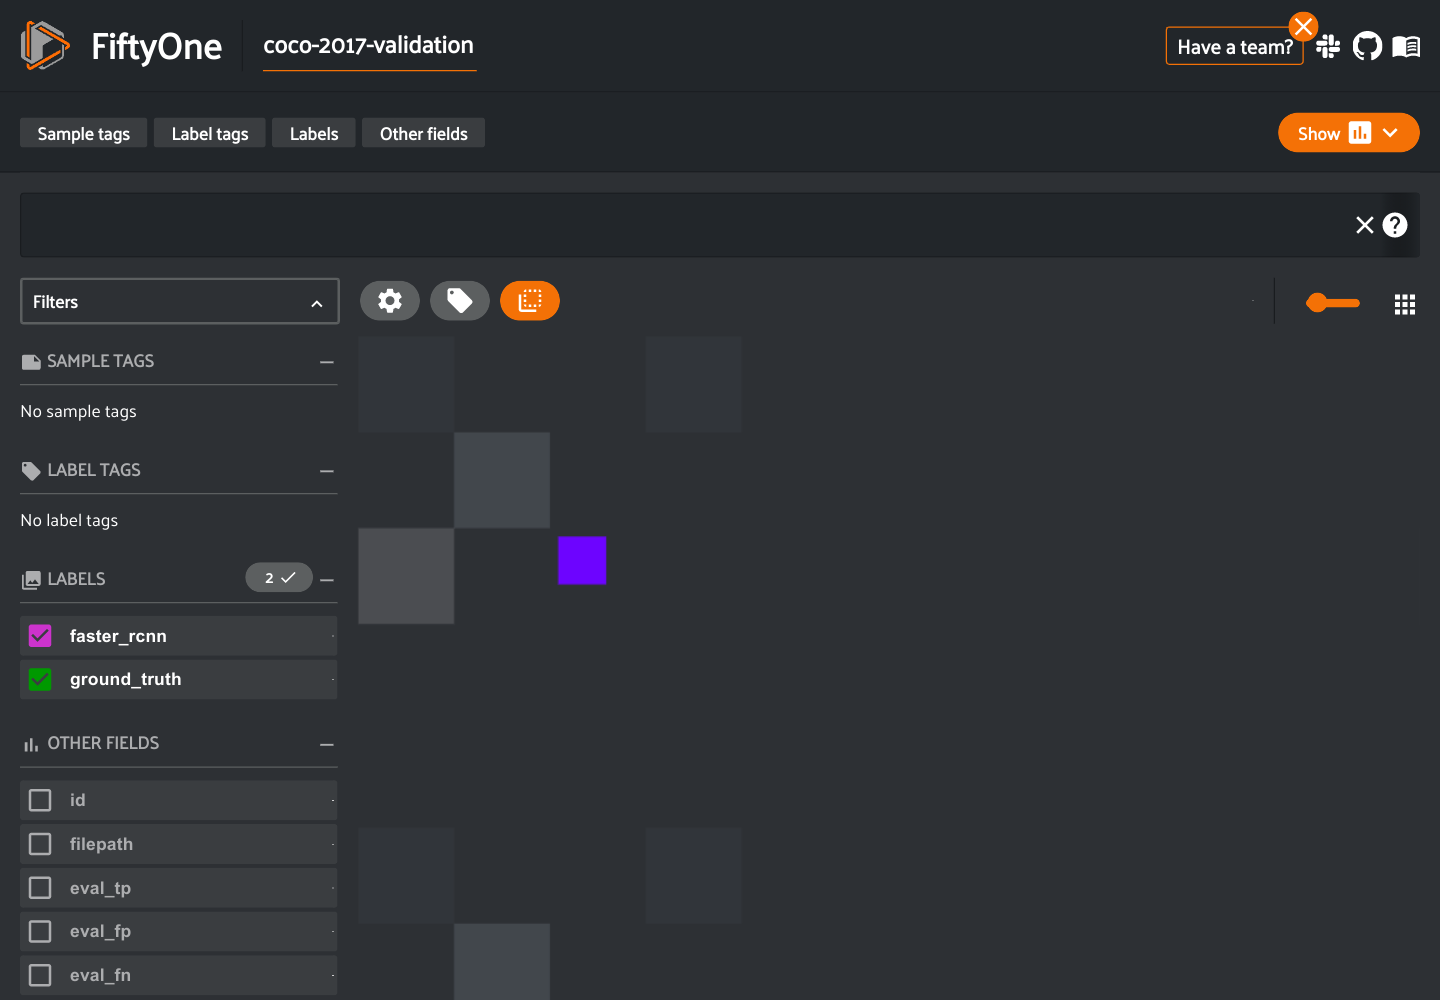

In [40]:
session.view = high_conf_view.sort_by("eval_fp", reverse=True)

Finally let’s open an expanded view of the sample with the most false positive predictions to investigate in more detail:


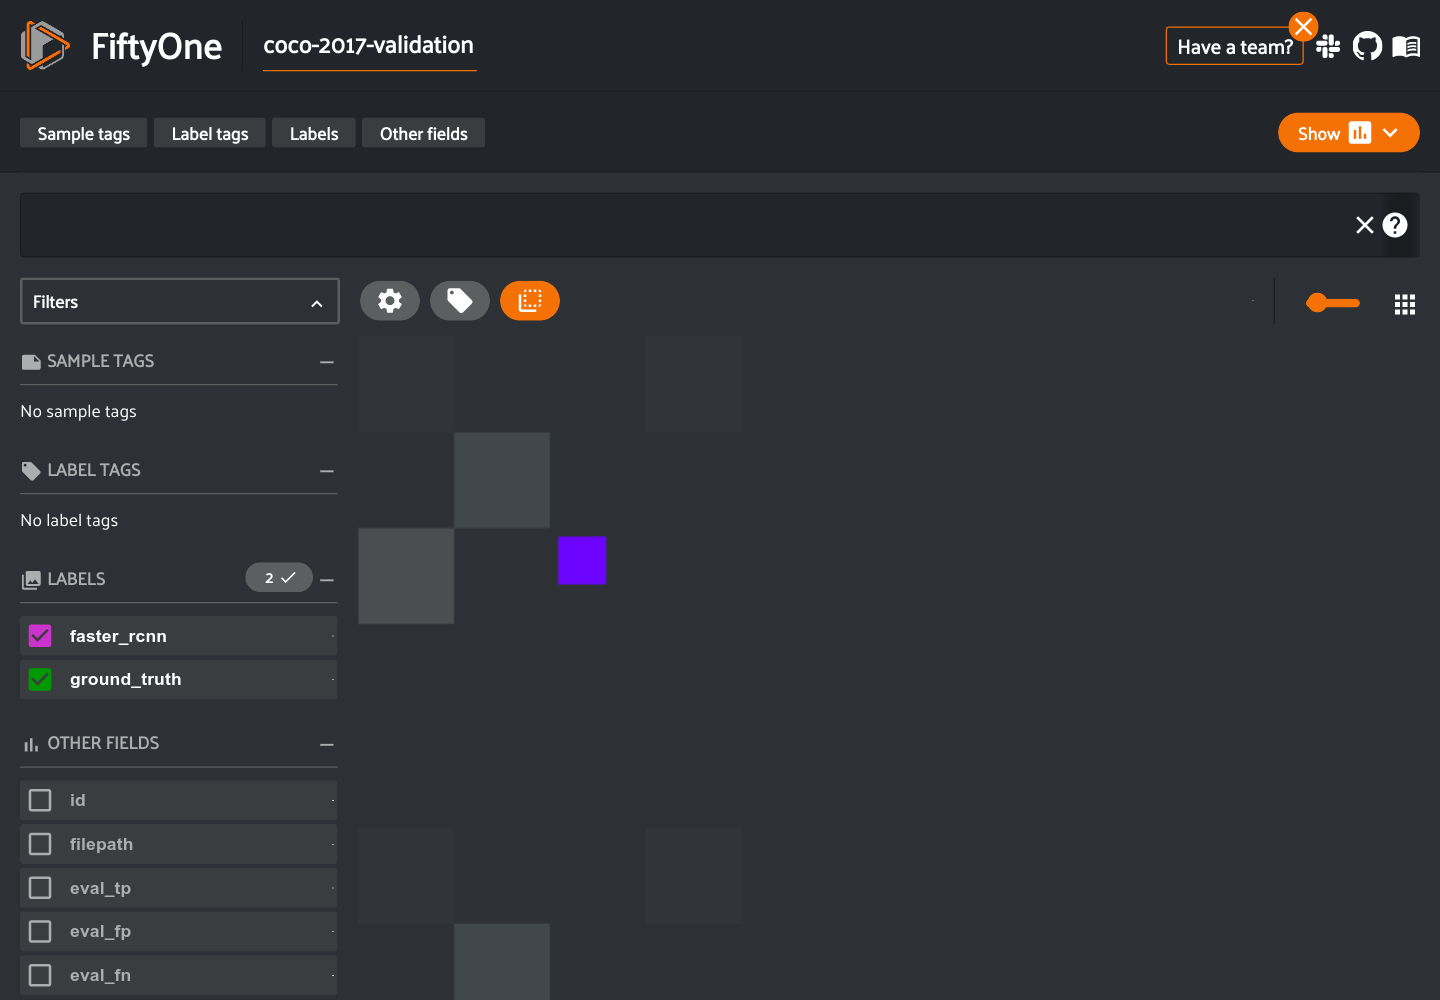

In [41]:
session.show()

**See anything interesting?**

What you find will likely be different because a random subset of samples were chosen. In our case, we find missing ground truth boxes for two of the laptop keyboards, a bottle, and even perhaps a cell phone. The model did not confidently predict many of the boxes in this image, but from a high-level, an example like this makes us consider the consequences of including complex or dense images in datasets. It will likely mean incorrect or incomplete ground truth annotations the annotators are not diligent! And that ultimately leads to confused models, and misinformed evaluations.

This conclusion would have been nearly impossible to achieve without visually inspecting the individual samples in the dataset according to the variety of criteria that we considered in this tutorial.



In [42]:
session.freeze()  # screenshot the active App for sharing

### Tagging and next steps

In practice, the next step is to take action on the issues that we identified above. A natural first step is to tag the issues so they can be retrieved and dealt with later. FiftyOne provides support for [tagging samples and labels](https://voxel51.com/docs/fiftyone/user_guide/app.html#tags-and-tagging), both programmatically and via the App.

In your App instance, try tagging the predictions with missing ground truth detections. You can do this by clicking on the boxes of the predictions of interest and using the tagging element in the top-right corner to assign a ```possibly-missing``` tag.

Alternatively, we can programmatically tag a batch of labels by creating a view that contains the objects of interest and then applying [tag_labels()](https://voxel51.com/docs/fiftyone/user_guide/fiftyone.core.collections.html?highlight=tag_labels#fiftyone.core.collections.SampleCollection.tag_labels):

In [43]:
# Tag all highly confident false positives as "possibly-missing"
(
    high_conf_view
        .filter_labels("faster_rcnn", F("eval") == "fp")
        .select_fields("faster_rcnn")
        .tag_labels("possibly-missing")
)

These tagged labels could then be sent off to our annotation provider of choice for review and addition to the ground truth labels. FiftyOne currently offers integrations for [Scale AI](https://voxel51.com/docs/fiftyone/api/fiftyone.utils.scale.html), [Labelbox](https://voxel51.com/docs/fiftyone/api/fiftyone.utils.labelbox.html), and [CVAT](https://voxel51.com/docs/fiftyone/api/fiftyone.types.dataset_types.html?highlight=cvat#fiftyone.types.dataset_types.CVATImageDataset).
For example, the snippet below exports the tagged labels and their source media to disk in CVAT format:

In [44]:
# Export all labels with the `possibly-missing` tag in CVAT format
(
    dataset
        .select_labels(tags=["possibly-missing"])
        .export("fiftyone/coco/possibly-missing", fo.types.CVATImageDataset)
)

Directory 'fiftyone/coco/possibly-missing' already exists; export will be merged with existing files
Found multiple fields ['ground_truth', 'faster_rcnn'] with compatible type <class 'fiftyone.core.labels.Detections'>; exporting 'ground_truth'
 100% |███████████████████| 62/62 [254.1ms elapsed, 0s remaining, 244.0 samples/s]      


In [1]:
%reset -f

# User Guide
## FiftyOne Basics

This page provides a brief overview of FiftyOne’s basic concepts.
![datasets](images/datasets-hero.png)

### Datasets

The ```Dataset``` class is the core data structure in FiftyOne, allowing you to represent your data and manipulate it through the Python library and the [FiftyOne App](https://voxel51.com/docs/fiftyone/user_guide/app.html#fiftyone-app).

FiftyOne Datasets allow you to easily [load](https://voxel51.com/docs/fiftyone/user_guide/dataset_creation/index.html#loading-datasets), [modify](https://voxel51.com/docs/fiftyone/user_guide/using_datasets.html#using-datasets), [visualize](https://voxel51.com/docs/fiftyone/user_guide/app.html#fiftyone-app), and [evaluate](https://voxel51.com/docs/fiftyone/user_guide/evaluation.html#evaluating-models) your data along with any related labels (classifications, detections, etc). They provide a consistent interface for loading images, videos, annotations, and model predictions into a format that can be visualized in the [FiftyOne App](https://voxel51.com/docs/fiftyone/user_guide/app.html#fiftyone-app), synced with your annotation source, and shared with others.

If you have your own collection of data, loading it as a ```Dataset``` will allow you to easily search and sort your samples. You can use FiftyOne to identify unique samples as well as possible mistakes in your labels.

If you are training a model, its predictions and associated data such as embeddings and logits can be loaded into your ```Dataset```. The FiftyOne App makes it easy to visually debug what your model has learned, even for complex label types like polygons and segmentation masks. With this knowledge, you can update your ```Dataset``` to include more representative samples and samples that your model found difficult into your training set.

> NOTE
> Check out [creating FiftyOne datasets](https://voxel51.com/docs/fiftyone/user_guide/dataset_creation/index.html#loading-datasets) for more information about loading your data into FiftyOne.

A ```Dataset``` is composed of multiple ```Sample``` objects which contain ```Field``` attributes, all of which can be dynamically created, modified and deleted. FiftyOne uses a lightweight non-relational database to store datasets, so you can easily scale to datasets of any size without worrying about RAM constraints on your machine.

Datasets are ordered collections of samples. When a ```Sample``` is added to a ```Dataset```, it is assigned a unique ID that can be used to retrieve the sample from the dataset.

Slicing and other batch operations on datasets are done through the use of ```dataset views```. A ```DatasetView``` provides a view into the ```Dataset```, which can be filtered, sorted, sampled, etc. along various axes to obtain a desired subset of the samples.

In [2]:
import fiftyone as fo

# Create an empty dataset
dataset = fo.Dataset("test-dataset")

print(dataset)

Name:        test-dataset
Media type:  None
Num samples: 0
Persistent:  False
Tags:        []
Sample fields:
    id:       fiftyone.core.fields.ObjectIdField
    filepath: fiftyone.core.fields.StringField
    tags:     fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)


### Samples

Samples are the atomic elements of a ```Dataset``` that store all the information related to a given piece of data (e.g., an image or video).

All ```Sample``` instances store the path to their source data on disk in their ```filepath``` field. Any number of fields can be dynamically added to samples to store additional custom information about the sample.

In [16]:
import fiftyone as fo

dataset=fo.Dataset()
# An image sample
sample = fo.Sample(filepath="img/stinkbug.png", ground_truth=fo.Detections(
    detections=[
        fo.Detection(label="CAT", bounding_box=[0.1, 0.1, 0.4, 0]),
        fo.Detection(label="dog", bounding_box=[0.5, 0.5, 0, 0.4]),
    ]
))
for i in range(10):
    dataset.add_sample(sample)

print(len(dataset))

# A video sample
# sample = fo.Sample(filepath="/path/to/video.mp4")

10


In [17]:
print(type(sample['ground_truth'].detections))

for sample in dataset:
    i = 0
    while i < len(sample.ground_truth.detections):
        x, y, w, h = sample.ground_truth.detections[i]['bounding_box']
        if w == 0 or h == 0:
            sample.ground_truth.detections.pop(i)
            sample.save()
            continue
        i += 1

for sample in dataset:
    print(sample)

# print(sample)


<class 'mongoengine.base.datastructures.BaseList'>
<Sample: {
    'id': '6243be48f2cb0525956ca50b',
    'media_type': 'image',
    'filepath': '/home/andrew/projects/python/python_tutorial/img/stinkbug.png',
    'tags': BaseList([]),
    'metadata': None,
    'ground_truth': <Detections: {'detections': BaseList([])}>,
}>
<Sample: {
    'id': '6243be48f2cb0525956ca510',
    'media_type': 'image',
    'filepath': '/home/andrew/projects/python/python_tutorial/img/stinkbug.png',
    'tags': BaseList([]),
    'metadata': None,
    'ground_truth': <Detections: {'detections': BaseList([])}>,
}>
<Sample: {
    'id': '6243be48f2cb0525956ca515',
    'media_type': 'image',
    'filepath': '/home/andrew/projects/python/python_tutorial/img/stinkbug.png',
    'tags': BaseList([]),
    'metadata': None,
    'ground_truth': <Detections: {'detections': BaseList([])}>,
}>
<Sample: {
    'id': '6243be48f2cb0525956ca51a',
    'media_type': 'image',
    'filepath': '/home/andrew/projects/python/python_tuto

### Fields

Fields are attributes of ```Sample``` instances that store customizable information about the samples. Thinking of a ```Dataset``` as a table where each row is a ```Sample```, each column of the table is a ```Field```.

All samples must have their ```filepath``` field populated, which points to the source data for the sample on disk. By default, samples are also given ```id```, ```media_type```, ```metadata```, and ```tags``` fields that store common information:

In [6]:
print(sample)

<Sample: {
    'id': None,
    'media_type': 'image',
    'filepath': '/home/andrew/projects/python/python_tutorial/img/stinkbug.png',
    'tags': [],
    'metadata': None,
    'ground_truth': <Detections: {
        'detections': BaseList([
            <Detection: {
                'id': '6242f290899a42af4433d838',
                'attributes': BaseDict({}),
                'tags': BaseList([]),
                'label': 'CAT',
                'bounding_box': BaseList([0.1, 0.1, 0.4, 0.4]),
                'mask': None,
                'confidence': None,
                'index': None,
            }>,
            <Detection: {
                'id': '6242f290899a42af4433d839',
                'attributes': BaseDict({}),
                'tags': BaseList([]),
                'label': 'dog',
                'bounding_box': BaseList([0.5, 0.5, 0, 0.4]),
                'mask': None,
                'confidence': None,
                'index': None,
            }>,
        ]),
    }>,
}>


Custom fields can contain any Python primitive data type:

- BooleanField: contains Python ```bool``` instances

- IntField: contains Python ```int``` instances

- FloatField: contains Python ```float``` instances

- StringField: contains Python ```str``` instances

- DateField: contains Python ```date``` instances

- DateTimeField: contains Python ```datetime``` instances

- ListField: contains Python ```list``` instances

- DictField: contains Python ```dict``` instances

The elements of list and dict fields may be homogenous or heterogenous, and may even contain nested lists and dicts. Fields can also contain more complex data types like [labels](https://voxel51.com/docs/fiftyone/user_guide/using_datasets.html#using-labels).

Fields can be dynamically created, modified, and deleted. When a new ```Field``` is assigned to a ```Sample``` in a ```Dataset```, or a ```Sample``` with new fields is added to a ```Dataset```, the appropriate fields are automatically added to the dataset’s schema and thus accessible on all other samples in the dataset.

> NOTE
> If a ```Field``` has not been set on a particular ```Sample``` in a ```Dataset```, its value will be ```None```.

In [6]:
sample["quality"]=89.7
sample["keypoints"] = [[31, 27], [63, 72]]
sample["geo_json"] = {
    "type": "Feature",
    "geometry": {"type": "Point", "coordinates": [125.6, 10.1]},
    "properties": {"name": "camera"},
}
dataset.add_sample(sample)
print(sample)
print(dataset)

<Sample: {
    'id': '6241157457fb2d63a9dfb1dc',
    'media_type': 'image',
    'filepath': '/home/andrew/projects/python/python_tutorial/img/stinkbug.png',
    'tags': BaseList([]),
    'metadata': None,
    'quality': 89.7,
    'keypoints': BaseList([BaseList([31, 27]), BaseList([63, 72])]),
    'geo_json': BaseDict({
        'type': 'Feature',
        'geometry': BaseDict({
            'type': 'Point',
            'coordinates': BaseList([125.6, 10.1]),
        }),
        'properties': BaseDict({'name': 'camera'}),
    }),
}>
Name:        test-dataset
Media type:  image
Num samples: 2
Persistent:  False
Tags:        []
Sample fields:
    id:        fiftyone.core.fields.ObjectIdField
    filepath:  fiftyone.core.fields.StringField
    tags:      fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:  fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    quality:   fiftyone.core.fields.FloatField
    keypoints: fiftyone.core.fields.Li

### Tags

All ```Sample``` instances have a ```tags``` attribute, which stores a list of strings that can be used flexibly to store information about a sample.

A typical use case is to tag the dataset split (```test```, ```train```, ```validation```) to which the ```Sample``` belongs. However, you are free to use tags however you like.

In [7]:
sample.tags.append("my_favorite_samples")

print(sample.tags)

['my_favorite_samples']


### Metadata

All ```Sample``` instances have a ```metadata``` attribute that stores type-specific metadata about the source media of the sample.

In [8]:
dataset.compute_metadata()
print(dataset.first())

Computing image metadata...
 100% |█████████████████████| 2/2 [317.4ms elapsed, 0s remaining, 6.3 samples/s] 
<Sample: {
    'id': '6241157457fb2d63a9dfb1dc',
    'media_type': 'image',
    'filepath': '/home/andrew/projects/python/python_tutorial/img/stinkbug.png',
    'tags': BaseList([]),
    'metadata': <ImageMetadata: {
        'size_bytes': 108161,
        'mime_type': 'image/png',
        'width': 500,
        'height': 375,
        'num_channels': 3,
    }>,
    'quality': 89.7,
    'keypoints': BaseList([BaseList([31, 27]), BaseList([63, 72])]),
    'geo_json': BaseDict({
        'type': 'Feature',
        'geometry': BaseDict({
            'type': 'Point',
            'coordinates': BaseList([125.6, 10.1]),
        }),
        'properties': BaseDict({'name': 'camera'}),
    }),
}>


Labels

Labels store semantic information about the sample, such as ground annotations or model predictions.

FiftyOne provides a Label subclass for many common tasks:

- Regression: a regression value

- Classification: a classification label

- Classifications: a list of classifications (typically for multilabel tasks)

- Detections: a list of object detections (with optional instance masks)

- Polylines: a list of polylines or polygons in an image

- Keypoints: a list of keypoints in an image

- Segmentation: a semantic segmentation mask for an image

- Heatmap: an intensity heatmap for an image

- Temporal detection: events with a temporal frame support in a video

- GeoLocation: geolocation point(s), line(s), or polygon(s)

Using FiftyOne’s Label types enables you to visualize your labels in the the App.

In [9]:
sample["weather"] = fo.Classification(label="sunny")
sample["animals"] = fo.Detections(
    detections=[
        fo.Detection(label="cat", bounding_box=[0.5, 0.5, 0.4, 0.3]),
        fo.Detection(label="dog", bounding_box=[0.2, 0.2, 0.2, 0.4]),
    ]
)

print(sample)

<Sample: {
    'id': '6241157457fb2d63a9dfb1dc',
    'media_type': 'image',
    'filepath': '/home/andrew/projects/python/python_tutorial/img/stinkbug.png',
    'tags': BaseList([]),
    'metadata': <ImageMetadata: {
        'size_bytes': 108161,
        'mime_type': 'image/png',
        'width': 500,
        'height': 375,
        'num_channels': 3,
    }>,
    'quality': 89.7,
    'keypoints': BaseList([BaseList([31, 27]), BaseList([63, 72])]),
    'geo_json': BaseDict({
        'type': 'Feature',
        'geometry': BaseDict({
            'type': 'Point',
            'coordinates': BaseList([125.6, 10.1]),
        }),
        'properties': BaseDict({'name': 'camera'}),
    }),
    'weather': <Classification: {
        'id': '6241177f57fb2d63a9dfb1de',
        'tags': BaseList([]),
        'label': 'sunny',
        'confidence': None,
        'logits': None,
    }>,
    'animals': <Detections: {
        'detections': BaseList([
            <Detection: {
                'id': '6241177

In [10]:
%reset -f

### DatasetViews

Dataset views are a powerful tool for exploring your datasets. You can use ```DatasetView``` instances to search, filter, sort, and manipulate subsets of your datasets to perform the analysis that you need.

In [1]:
import fiftyone as fo
import fiftyone.zoo as foz
import fiftyone.brain as fob
from fiftyone import ViewField as F

dataset = foz.load_zoo_dataset("cifar10", split="test",dataset_dir="fiftyone/cifar10")

cats = dataset.match(F("ground_truth.label") == "cat")
fob.compute_uniqueness(cats)

similar_cats = cats.sort_by("uniqueness", reverse=False)

session = fo.launch_app(view=similar_cats)

Split 'test' already downloaded
Loading 'cifar10' split 'test'
 100% |█████████████| 10000/10000 [4.9s elapsed, 0s remaining, 2.0K samples/s]      
Dataset 'cifar10-test' created
Computing embeddings...
  13% |█/-------------|  128/1000 [4.3s elapsed, 29.3s remaining, 29.8 samples/s] 

/home/andrew/miniconda3/envs/pytorch/lib/python3.9/site-packages/fiftyone/utils/torch.py:636: RuntimeWarning: overflow encountered in exp
  odds = np.exp(logits)
/home/andrew/miniconda3/envs/pytorch/lib/python3.9/site-packages/fiftyone/utils/torch.py:637: RuntimeWarning: invalid value encountered in true_divide
  odds /= np.sum(odds, axis=1, keepdims=True)


 100% |███████████████| 1000/1000 [13.9s elapsed, 0s remaining, 80.7 samples/s]      
Computing uniqueness...
Uniqueness computation complete


### Aggregations

Dataset views allow you to search for samples in your datasets and filter their contents. Complementary to this, one is often interested in computing aggregate statistics about a dataset or view, such as label counts, distributions, and ranges.

FiftyOne provides a powerful [aggregations framework](https://voxel51.com/docs/fiftyone/user_guide/using_aggregations.html#using-aggregations) that provides a highly-efficient approach to computing statistics about your data.

In [2]:
import fiftyone as fo
import fiftyone.zoo as foz
from fiftyone import ViewField as F

dataset = foz.load_zoo_dataset("quickstart",dataset_dir="fiftyone/quickstart")

# Compute a histogram of the predicted labels in the `predictions` field
print(dataset.count_values("predictions.detections.label"))
# {'bicycle': 13, 'hot dog': 8, ..., 'skis': 52}

# Compute the range of confidences of `cat` predictions in the dataset
print(
    dataset
    .filter_labels("predictions", F("label") == "cat")
    .bounds("predictions.detections.confidence")
)
# (0.05223553627729416, 0.9965479969978333)

Dataset already downloaded
Loading 'quickstart'
 100% |█████████████████| 200/200 [3.5s elapsed, 0s remaining, 52.6 samples/s]      
Dataset 'quickstart' created
{'donut': 36, 'cow': 80, 'bottle': 90, 'backpack': 70, 'hot dog': 8, 'horse': 63, 'book': 146, 'truck': 88, 'fire hydrant': 6, 'orange': 18, 'refrigerator': 14, 'suitcase': 18, 'traffic light': 60, 'spoon': 59, 'clock': 28, 'bear': 12, 'pizza': 39, 'apple': 28, 'bench': 69, 'teddy bear': 7, 'fork': 61, 'potted plant': 44, 'tv': 16, 'surfboard': 126, 'umbrella': 69, 'chair': 152, 'boat': 181, 'banana': 69, 'skis': 52, 'toaster': 2, 'zebra': 25, 'dog': 49, 'cat': 35, 'bowl': 86, 'keyboard': 6, 'hair drier': 4, 'tie': 45, 'motorcycle': 64, 'baseball glove': 8, 'toilet': 4, 'cup': 93, 'dining table': 172, 'knife': 65, 'couch': 33, 'giraffe': 58, 'snowboard': 18, 'parking meter': 2, 'broccoli': 154, 'frisbee': 9, 'sheep': 30, 'wine glass': 31, 'cell phone': 31, 'carrot': 384, 'laptop': 16, 'sink': 90, 'bird': 133, 'sandwich': 24, '

In [3]:
%reset -f

## Loading data into FiftyOne

The first step to using FiftyOne is to load your data into a [dataset](https://voxel51.com/docs/fiftyone/user_guide/using_datasets.html#using-datasets). FiftyOne supports automatic loading of datasets stored in various [common formats](https://voxel51.com/docs/fiftyone/user_guide/dataset_creation/datasets.html#supported-import-formats). If your dataset is stored in a custom format, don’t worry, FiftyOne also provides support for easily loading datasets in [custom formats](https://voxel51.com/docs/fiftyone/user_guide/dataset_creation/index.html#loading-custom-datasets).

> NOTE
> 
> When you create a ```Dataset```, its samples and all of their fields (metadata, labels, custom fields, etc.) are written to FiftyOne’s backing database.
> 
> Important: Samples only store the ```filepath``` to the media, not the raw media itself. FiftyOne does not create duplicate copies of your data!

### Common formats

If your data is stored on disk in one of the [many common formats](https://voxel51.com/docs/fiftyone/user_guide/dataset_creation/datasets.html#supported-import-formats) supported natively by FiftyOne, then you can automatically load your data into a ```Dataset``` via the following simple pattern:


In [6]:
import fiftyone as fo

# The directory containing the dataset to import
dataset_dir = "fiftyone/coco/validation"

# The type of the dataset being imported
dataset_type = fo.types.COCODetectionDataset  # for example

dataset = fo.Dataset.from_dir(
    dataset_dir=dataset_dir,
    dataset_type=dataset_type
)

 100% |███████████████| 5000/5000 [23.6s elapsed, 0s remaining, 240.0 samples/s]      


> NOTE
>
> Check out [this page](https://voxel51.com/docs/fiftyone/user_guide/dataset_creation/datasets.html#loading-datasets-from-disk) for more details about loading datasets from disk in common formats!

### Custom formats

The simplest and most flexible approach to loading your data into FiftyOne is to iterate over your data in a simple Python loop, create a ```Sample``` for each data + label(s) pair, and then add those samples to a ```Dataset```.

FiftyOne provides ```label types``` for common tasks such as classification, detection, segmentation, and many more. The examples below give you a sense of the basic workflow for a few tasks:

In [ ]:
# import glob
# import fiftyone as fo

# images_patt = "/path/to/images/*"

# # Ex: your custom label format
# annotations = {
#     "/path/to/images/000001.jpg": "dog",
#     ....,
# }

# # Create samples for your data
# samples = []
# for filepath in glob.glob(images_patt):
#     sample = fo.Sample(filepath=filepath)

#     # Store classification in a field name of your choice
#     label = annotations[filepath]
#     sample["ground_truth"] = fo.Classification(label=label)

#     samples.append(sample)

# # Create dataset
# dataset = fo.Dataset("my-classification-dataset")
# dataset.add_samples(samples)

Note that using [Dataset.add_samples()](https://voxel51.com/docs/fiftyone/api/fiftyone.core.dataset.html#fiftyone.core.dataset.Dataset.add_samples) to add batches of samples to your datasets can be significantly more efficient than adding samples one-by-one via [Dataset.add_sample()](https://voxel51.com/docs/fiftyone/api/fiftyone.core.dataset.html#fiftyone.core.dataset.Dataset.add_sample).

> Note
>
> If you use the same custom data format frequently in your workflows, then writing a [custom dataset importer](https://voxel51.com/docs/fiftyone/user_guide/dataset_creation/datasets.html#custom-dataset-importer) is a great way to abstract and streamline the loading of your data into FiftyOne.
### Loading images

If you’re just getting started with a project and all you have is a bunch of image files, you can easily load them into a FiftyOne dataset and start visualizing them [in the App](https://voxel51.com/docs/fiftyone/user_guide/app.html#fiftyone-app):

In [ ]:
# import fiftyone as fo

# # Create a dataset from a list of images
# dataset = fo.Dataset.from_images(
#     ["/path/to/image1.jpg", "/path/to/image2.jpg", ...]
# )

# # Create a dataset from a directory of images
# dataset = fo.Dataset.from_images_dir("/path/to/images")

# # Create a dataset from a glob pattern of images
# dataset = fo.Dataset.from_images_patt("/path/to/images/*.jpg")

# session = fo.launch_app(dataset)

Loading videos

If you’re just getting started with a project and all you have is a bunch of video files, you can easily load them into a FiftyOne dataset and start visualizing them [in the App](https://voxel51.com/docs/fiftyone/user_guide/app.html#fiftyone-app):

In [ ]:
# import fiftyone as fo

# # Create a dataset from a list of videos
# dataset = fo.Dataset.from_videos(
#     ["/path/to/video1.mp4", "/path/to/video2.mp4", ...]
# )

# # Create a dataset from a directory of videos
# dataset = fo.Dataset.from_videos_dir("/path/to/videos")

# # Create a dataset from a glob pattern of videos
# dataset = fo.Dataset.from_videos_patt("/path/to/videos/*.mp4")

# session = fo.launch_app(dataset)

Model predictions

Once you’ve created a dataset and ground truth labels, you can easily add model predictions to take advantage of FiftyOne’s [evaluation capabilities](https://voxel51.com/docs/fiftyone/user_guide/evaluation.html#evaluating-models).


In [ ]:
# import fiftyone as fo
# import fiftyone.zoo as foz
# import fiftyone.utils.coco as fouc

# dataset = foz.load_zoo_dataset("quickstart")
# classes = dataset.distinct("predictions.detections.label")

# # Export images and ground truth labels to disk
# dataset.export(
#     export_dir="/tmp/coco",
#     dataset_type=fo.types.COCODetectionDataset,
#     classes=classes,
#     label_field="ground_truth",
# )

# # Export predictions
# dataset.export(
#     dataset_type=fo.types.COCODetectionDataset,
#     labels_path="/tmp/coco/predictions.json",
#     classes=classes,
#     label_field="predictions",
# )

# # Now load ground truth labels into a new dataset
# dataset2 = fo.Dataset.from_dir(
#     dataset_dir="/tmp/coco",
#     dataset_type=fo.types.COCODetectionDataset,
#     label_field="ground_truth",
# )

# # And add model predictions
# fouc.add_coco_labels(
#     dataset2,
#     "predictions",
#     "/tmp/coco/predictions.json",
#     classes=classes,
# )

# # Verify that ground truth and predictions were imported as expected
# print(dataset.count("ground_truth.detections"))
# print(dataset2.count("ground_truth.detections"))
# print(dataset.count("predictions.detections"))
# print(dataset2.count("predictions.detections"))

> NOTE
>
> See [add_coco_labels()](https://voxel51.com/docs/fiftyone/api/fiftyone.utils.coco.html#fiftyone.utils.coco.add_coco_labels) for a complete description of the available syntaxes for loading COCO-formatted predictions to an existing dataset.

### Need data?

The [FiftyOne Dataset Zoo](https://voxel51.com/docs/fiftyone/user_guide/dataset_zoo/index.html#dataset-zoo) contains dozens of popular public datasets that you can load into FiftyOne in a single line of code:

In [ ]:
# import fiftyone.zoo as foz

# # List available datasets
# print(foz.list_zoo_datasets())
# # ['coco-2014', ...,  'kitti', ..., 'voc-2012', ...]

# # Load a split of a zoo dataset
# dataset = foz.load_zoo_dataset("cifar10", split="train")

> Note
>
> Check out the [available zoo datasets](https://voxel51.com/docs/fiftyone/user_guide/dataset_zoo/datasets.html#dataset-zoo-datasets)!


In [10]:
import fiftyone as fo
for dsname in fo.list_datasets():
    dataset=fo.load_dataset(dsname)
    dataset.delete()
fo.list_datasets()

[]